## Implement Quasiparticle Hamiltonian on a Digital Quantum Computer

In [1]:
import qiskit
import numpy as np
from qiskit.quantum_info import SparsePauliOp

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from typing import Dict


Load matrix elements for $^{6}He$

In [2]:
data_onebody=np.load('data/matrix_elements_h_eff_2body/one_body_nn_p.npz')
keys=data_onebody['keys']
values=data_onebody['values']
n_qubits=3

t_onebody={}

for a,key in enumerate(keys):
    i,j=key
    t_onebody[(i,j)]=values[a]

print(t_onebody)
t_onebody.pop((0,1))
t_onebody.pop((0,2))
t_onebody.pop((1,2))

print(t_onebody)

{(0, 0): 1.5678999999999998, (0, 1): 1.0430999999999995, (0, 2): -3.763858685577873, (1, 0): 1.0430999999999995, (1, 1): 1.5678999999999998, (1, 2): 3.763858685577873, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): 4.8797}
{(0, 0): 1.5678999999999998, (1, 0): 1.0430999999999995, (1, 1): 1.5678999999999998, (2, 0): -3.763858685577873, (2, 1): 3.763858685577873, (2, 2): 4.8797}


#### Build-up $H_Q$

In [3]:
def get_hamiltonian(t_onebody:Dict, n_sites:int):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    XX_tuples=[]
    YY_tuples=[]
    Z_tuples=[]
    I_tuples=[]
    for (i,j),t_val in t_onebody.items():
    
        if i==j:
            Z_tuples.append(("Z", [i], -0.5*t_val))
            I_tuples.append(('I',[i],0.5*t_val)) 
        else:
            XX_tuples.append( ("XX", [i, j], 0.5*t_val) )
            YY_tuples.append(("YY", [i, j], 0.5*t_val) )
            
    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples,*Z_tuples,*I_tuples], num_qubits=n_sites)
    return hamiltonian.simplify()



Get the manybody basis

In [4]:
import numpy as np
from qiskit.quantum_info import Statevector

n_sites=n_qubits
basis_states = [Statevector.from_label(np.binary_repr(i, width=n_sites)) for i in range(2**n_sites)]

bitstring_to_index = {np.binary_repr(i, width=n_sites): i for i in range(2**n_sites)}
index_to_bitstring = {i: np.binary_repr(i, width=n_sites) for i in range(2**n_sites)}

In [5]:
print(index_to_bitstring)

{0: '000', 1: '001', 2: '010', 3: '011', 4: '100', 5: '101', 6: '110', 7: '111'}


In [6]:
hamiltonian_q=get_hamiltonian(t_onebody=t_onebody,n_sites=n_qubits)




#### Qiskit has the sick problem that the occupation value 1 becomes 0 (they define $S_z$ in the opposite way). Therefore, to select the Hamiltonian fixed in the one quasiparticle many-body basis we need to consider the conversion to the full bitstrig basis 

bitstring_index= 63- $2^{sp \; index}$

In [7]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_q.to_matrix())[2**(i-1),2**(j-1)]} \n')
        
### We got exactly the same Hamiltonian!

i=0,j=0 ->(1.5678999999999998+0j) 

i=0,j=1 ->(1.0430999999999995+0j) 

i=0,j=2 ->(-3.763858685577873+0j) 

i=1,j=0 ->(1.0430999999999995+0j) 

i=1,j=1 ->(1.5678999999999998+0j) 

i=1,j=2 ->(3.763858685577873+0j) 

i=2,j=0 ->(-3.763858685577873+0j) 

i=2,j=1 ->(3.763858685577873+0j) 

i=2,j=2 ->(4.8797+0j) 



Build up the total number of particles term

In [8]:
Z_tuples=[("Z", [i], -0.5) for i in range(n_qubits)]
I_tuples=[('I',[i],0.5) for i in range(n_qubits)]
n_operator = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)

print(n_operator.to_matrix())

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 3.+0.j]]


#### Build-up the driver Hamiltonian

In [17]:
coupling_term=-1.5678999999999998
Z_tuples=[("Z", [0], -0.5*coupling_term)]
I_tuples=[('I',[0],0.5*coupling_term)]

        
# We create the Hamiltonian as a SparsePauliOp, via the method
# `from_sparse_list`, and multiply by the interaction term.
hamiltonian_driver = SparsePauliOp.from_sparse_list([*Z_tuples,*I_tuples], num_qubits=n_qubits)


print(hamiltonian_driver)

SparsePauliOp(['IIZ', 'III'],
              coeffs=[ 0.78395+0.j, -0.78395+0.j])


In [18]:
from scipy.sparse import csr_matrix



for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        
        print(f'i={(i-1)},j={(j-1)} ->{csr_matrix(hamiltonian_driver.to_matrix())[2**(i-1),2**(j-1)]} \n')
        

i=0,j=0 ->(-1.5678999999999998+0j) 

i=0,j=1 ->0j 

i=0,j=2 ->0j 

i=1,j=0 ->0j 

i=1,j=1 ->0j 

i=1,j=2 ->0j 

i=2,j=0 ->0j 

i=2,j=1 ->0j 

i=2,j=2 ->0j 



#### Let's perform the SUZUKI-TROTTER

In [19]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector


Trotter-Time evolution without noise

In [20]:

#final_state=Statevector(circuit_opt)
time_steps=150
tf=15
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    for a in range(n_qubits):
        a_mb=2**(a)
        final_state=Statevector(circuit_time_evolution).data
        single_particle_vector[a_mb]=final_state[a_mb]
        psi_for_fidelity[a]=final_state[a_mb]
    energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
final_state=Statevector(circuit_time_evolution)

/tmp/ipykernel_2362206/1367391987.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


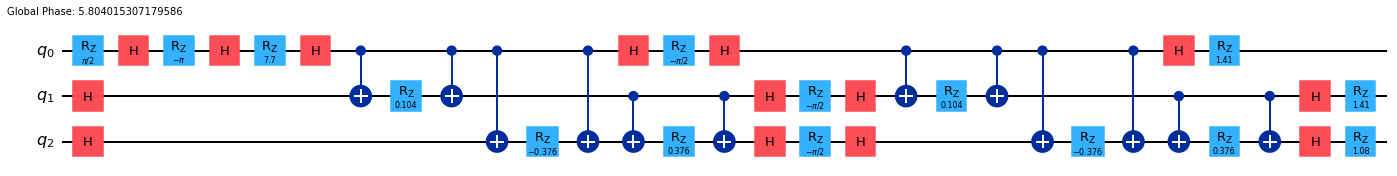

In [13]:
transpiled_circuit_time_evolution.draw()
from qiskit.visualization import circuit_drawer
circuit_drawer(transpiled_circuit_time_evolution, output='mpl', filename='qiskit_circuit.pdf', fold=-1)

In [24]:
data=np.load('data/quantum_annealing_pure_qa_6he.npz')

spectrum=data['spectrum']

energy=data['energy']

psi=data['psi_exact']

fidelity=data['fidelity']



In [25]:
fidelity_trotter_clean=psi_for_fidelity.conjugate().dot(psi)*np.conjugate(psi_for_fidelity.conjugate().dot(psi))
print(fidelity_trotter_clean,fidelity)

[0.97846766+4.03934915e-18j] (0.9813350752250924+0j)


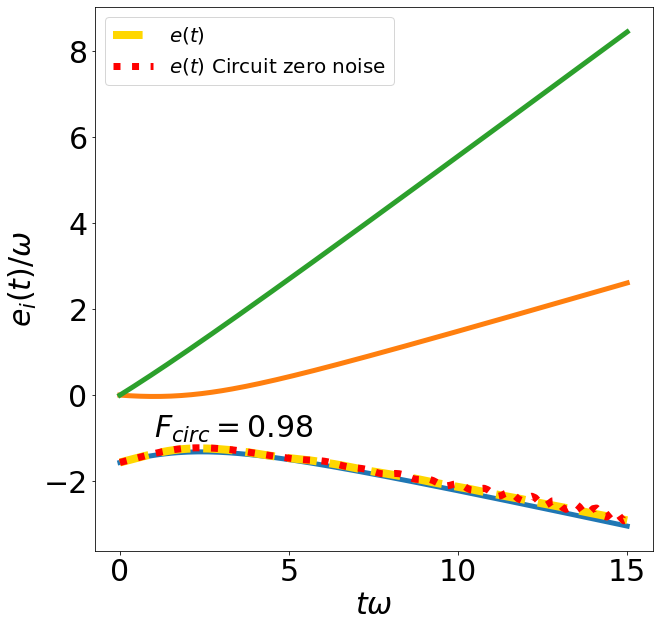

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(3):
    plt.plot(time,spectrum[:,i],linewidth=5)
plt.plot(time,energy,color='gold',linestyle='--',linewidth=8,label=r'$e(t)$')
plt.plot(time,energies_qiskit,color='red',linestyle=':',linewidth=7,label=r'$e(t)$ Circuit zero noise')
plt.tick_params(labelsize=30)
plt.xlabel(r'$t\omega$',fontsize=30)
plt.text(x=1,y=-1.,s=r'$F_{circ}=0.98$',fontsize=30)
plt.ylabel(r'$e_i(t)/\omega$',fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [30]:

print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_circuit_time_evolution.depth()}
             Gate count: {len(transpiled_circuit_time_evolution)}
    Nonlocal gate count: {transpiled_circuit_time_evolution.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_circuit_time_evolution.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 3581
             Gate count: 5369
    Nonlocal gate count: 1788
         Gate breakdown: RZ: 1790, H: 1790, CX: 1788, S: 1




#### Analysis of the Annealing with tunable noise

Imports

In [31]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake5QV1  # or another IBM backend
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix,state_fidelity
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

transpiled_circuit_time_evolution.save_density_matrix()

Only Depolarization CX

In [32]:

cx_error_rates=10**np.linspace(-5,-1,40)
infidelity=[]
energies_vs_noise=[]
conservation_check=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()

    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    #rz_depol = depolarizing_error(1e-5, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    #h_depol = depolarizing_error(1e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    #noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')


    # Add thermal relaxation errors
    # thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    # for gate in ['sx', 'rz', 'x']:
    #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise.append(eng_tau)
    infidelity.append(1-f_tau)
    conservation_check.append(n_conservation)

energies_vs_noise=np.asarray(energies_vs_noise)
infidelity=np.asarray(infidelity)
conservation_check=np.asarray(conservation_check)

0.014882319547876888
(-2.7791173835945315+5.415549799639294e-16j) 

0.018803597563124885
(-2.7506275351581833+1.7096089802755093e-16j) 

0.023743659628713942
(-2.7147224012094036-5.680083323661173e-17j) 

0.029958578678526582
(-2.6695301047092173+5.971767456093776e-16j) 

0.03776364596065207
(-2.6127409937293695+1.0110325885677391e-15j) 

0.047543967051504765
(-2.541526175983651-5.397776203090879e-16j) 

0.05976500523288841
(-2.4524539809584587+8.316292083984569e-16j) 

0.07498156904044395
(-2.3414140802011545-6.4621055054205325e-16j) 

0.09384267674070346
(-2.203566292591943-1.4645975916999093e-15j) 

0.11708819754684896
(-2.033341796855967+1.5939875355889089e-15j) 

0.14553111147451914
(-1.8245391702157994+5.169206504489281e-16j) 

0.1800167494926206
(-1.5705760645571933+1.4680405619918255e-15j) 

0.22134794081418696
(-1.2649768694583754+1.3979718476207431e-16j) 

0.2701637811423693
(-0.9021902922053497+1.2530228595787724e-15j) 

0.3267620832877446
(-0.47882347081627774+1.15135026457

Adding the one qubit error depolarization

In [33]:
cx_error_rates=10**np.linspace(-5,-1,40)
infidelity_1qerror=[]
energies_vs_noise_1qerror=[]
conservation_check_1qerror=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()

    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    #rz_depol = depolarizing_error(1e-5, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    h_depol = depolarizing_error(2.024e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    #noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    noise_model.add_all_qubit_quantum_error(h_depol, 'h')


    # Add thermal relaxation errors
    # thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    # for gate in ['sx', 'rz', 'x']:
    #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise_1qerror.append(eng_tau)
    infidelity_1qerror.append(1-f_tau)
    conservation_check_1qerror.append(n_conservation)

energies_vs_noise_1qerror=np.asarray(energies_vs_noise_1qerror)
infidelity_1qerror=np.asarray(infidelity_1qerror)
conservation_check_1qerror=np.asarray(conservation_check_1qerror)

0.2239818603264958
(-1.5478332908393408+9.263628941817363e-16j) 

0.2269392225413951
(-1.524638391966791+2.108805491572974e-15j) 

0.23066499252524797
(-1.4954056869187315+3.4631464866868126e-16j) 

0.2353523455628257
(-1.45861061360472+1.3384099843763074e-15j) 

0.24123915101869275
(-1.4123718128369394-4.499258417750565e-16j) 

0.24861598309165212
(-1.3543845739903446+2.3419740691178623e-15j) 

0.2578341025099542
(-1.2818524668715074-4.2245270701997833e-16j) 

0.2693122806484062
(-1.1914250196906-1.3124191665761578e-15j) 

0.28354053694065096
(-1.0791552196220033+2.206370419823939e-15j) 

0.3010777062597736
(-0.9404992948673616+9.923541846637156e-16j) 

0.3225382020047727
(-0.7703931844464327+3.0550053868932574e-16j) 

0.348561468469732
(-0.5634550868775161-4.115213058709896e-16j) 

0.37975577177985353
(-0.31437946691282637-2.048862774134959e-15j) 

0.41660704318999675
(-0.018599181569585177+1.2501993316863235e-15j) 

0.4593452168533185
(0.3267130894675181+1.5463316771223754e-16j) 

0

Adding decoherence

In [34]:
cx_error_rates=10**np.linspace(-5,-1,40)
infidelity_dec=[]
energies_vs_noise_dec=[]
conservation_check_dec=[]

for r,cx_error_rate in enumerate(cx_error_rates):

    # Create a noise model
    noise_model = NoiseModel()
    t1 = 220.96 * 1e3  # 225.54 us to ns
    t2 = 132.35 * 1e3  # 183.22 us to ns
    gate_time=68
    # Add gate errors
    cx_depol = depolarizing_error(cx_error_rate, 2)
    #rz_depol = depolarizing_error(1e-5, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    h_depol = depolarizing_error(2.024e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    #noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    noise_model.add_all_qubit_quantum_error(h_depol, 'h')


    # Add thermal relaxation errors
    thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    for gate in ['h', 'rz', 'x']:
        noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(transpiled_circuit_time_evolution, sim,optimization_level=3)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise_dec.append(eng_tau)
    infidelity_dec.append(1-f_tau)
    conservation_check_dec.append(n_conservation)

energies_vs_noise_dec=np.asarray(energies_vs_noise_dec)
infidelity_dec=np.asarray(infidelity_dec)
conservation_check_dec=np.asarray(conservation_check_dec)

0.6446695083934297
(1.406261934667885+5.773965284161662e-16j) 



0.6456796552713407
(1.4156223761574247-7.985676317293675e-16j) 



0.6469523441840304
(1.4274226023626637+6.711968323488688e-16j) 



0.6485536238002645
(1.4422805927227138+8.497961151804926e-16j) 



0.6505648526902096
(1.4609601347693868+1.4397620069682644e-16j) 



0.6530854619219908
(1.484398782224837+4.77298556063938e-16j) 



0.6562357225232642
(1.5137371647299327-3.8987128357396813e-16j) 



0.6601591398931639
(1.5503467962718922+1.319535384312385e-15j) 



0.6650238269600507
(1.5958512789702937-9.305935906251044e-16j) 



0.6710218174811097
(1.6521324637058856+4.885425045999518e-16j) 



0.6783647549508132
(1.7213084845623445+7.692637286676828e-16j) 



0.6872737551754848
(1.805664652571295-1.488492703836296e-16j) 



0.6979606070242392
(1.9075116439283692+7.210360361530745e-16j) 



0.7105971398476933
(2.028940256167413+7.776948022854216e-16j) 



0.7252701351731851
(2.171442602320763+1.9993170263532592e-16j) 



0.7419215725732236
(2.335383785749463-4.755615007159995e-16j) 



0.7602795662963059
(2.5193472683480467+8.573093893887889e-16j) 



0.7797951005108587
(2.7194531806330335-1.1473350515677294e-15j) 



0.7996128388000846
(2.928863599556172+3.1483626309445357e-16j) 



0.8186156126016793
(3.137813104856276-3.7523323751479e-16j) 

0.8355794129965185
(3.334549960789165-3.8457923693752854e-17j) 



0.8494418227057696
(3.5073967142100084-3.9598847237919875e-16j) 



0.8596147421862157
(3.6476166440079245-2.4111359085266943e-16j) 



0.8661923642487899
(3.7520177342904075-3.67940631713689e-16j) 



0.869898209729056
(3.823791042275997+4.274567441371693e-17j) 



0.8717524976543471
(3.8707233732440702+2.0915290587955698e-16j) 



0.8726570741920583
(3.9016589244045+3.464767124817666e-16j) 



0.8731660625239553
(3.923455004164864+1.0125415433525573e-16j) 



0.8735206964091428
(3.9400497541277986-1.3762334145205188e-16j) 



0.8737989910692716
(3.9532651235571046-1.9114892058784144e-17j) 



0.8740247166951417
(3.963936090585773+4.2762657407188676e-18j) 



0.8742088180449925
(3.972560168607755+2.607988655200277e-17j) 



0.8743588598960444
(3.979514556801421+2.2992778701534192e-18j) 



0.8744806388163178
(3.9851060809972485-2.4266756884025657e-18j) 



0.8745787776388935
(3.989586769851623-4.542609747029307e-19j) 



0.8746572142518169
(3.993164259853463+1.2558297483503156e-18j) 



0.874719499741134
(3.9960098009685074+2.0834247251800785e-18j) 



0.8747688411500113
(3.9982644758732917-2.0526969363683033e-18j) 



0.8748079837266243
(4.00004429518789-8.353086031976175e-19j) 

0.8748391124338373
(4.001444367476228+4.2166523370452373e-19j) 



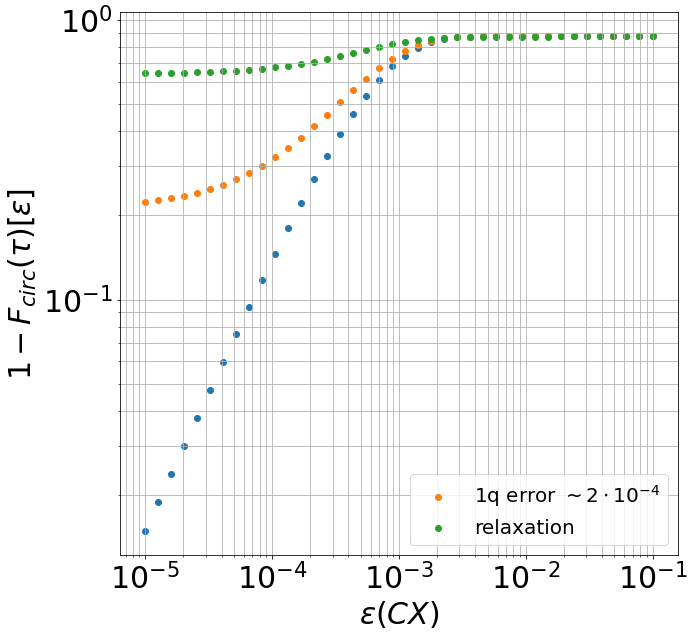

In [35]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,infidelity)
plt.scatter(cx_error_rates,infidelity_1qerror,label='1q error $\sim 2 \cdot 10^{-4}$')
plt.scatter(cx_error_rates,infidelity_dec,label='relaxation')
#plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$1-F_{circ}(\tau)[\epsilon]$',fontsize=30)

plt.show()

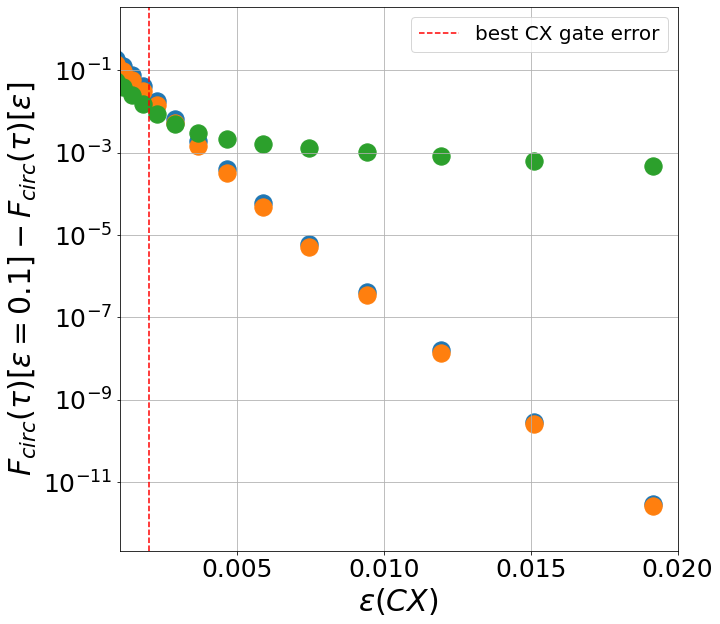

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,infidelity[-1]-infidelity+10**-12,s=300)
plt.scatter(cx_error_rates,infidelity_1qerror[-1]-infidelity_1qerror+10**-12,s=300)
plt.scatter(cx_error_rates,infidelity_dec[-1]-infidelity_dec+10**-12,s=300)
plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.semilogy()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=25)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.xlim([1*10**-3,0.02])
plt.ylabel(r'$F_{circ}(\tau)[\epsilon=0.1]-F_{circ}(\tau)[\epsilon]$',fontsize=30)

plt.show()

Combination of the two plots

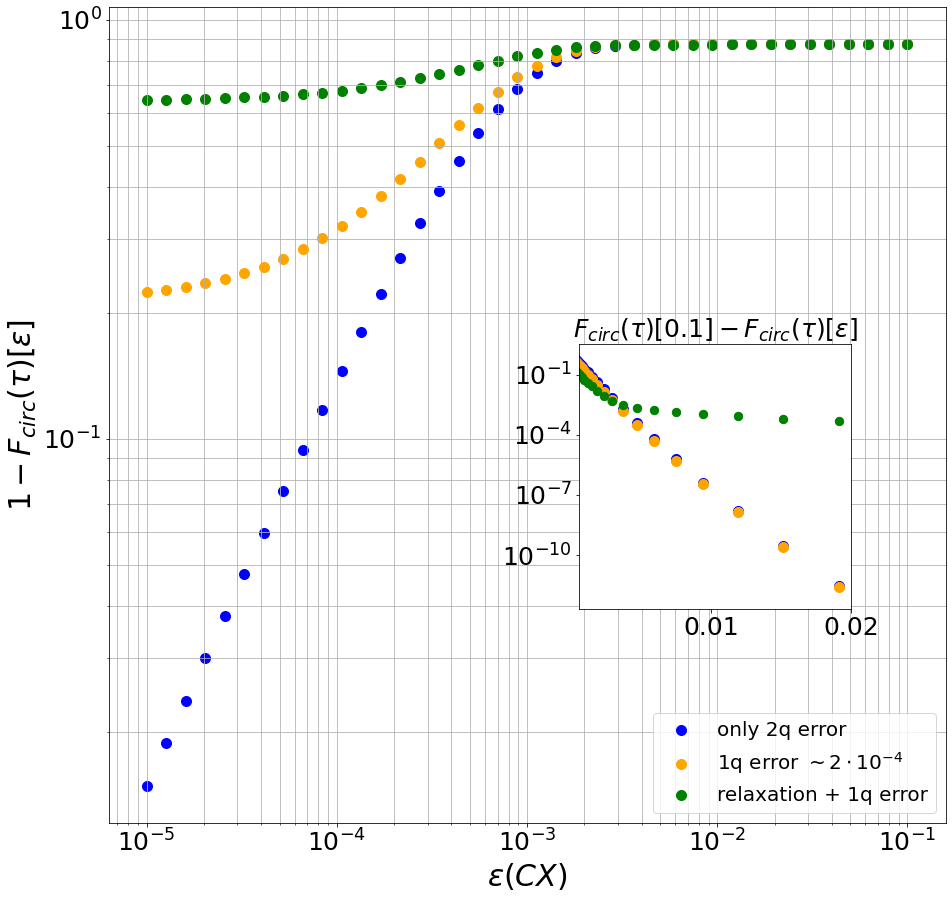

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(15, 15))

# === Main plot: 1 - Fidelity ===
ax.scatter(cx_error_rates, infidelity, color='blue', s=100,label='only 2q error')
ax.scatter(cx_error_rates,infidelity_1qerror,color='orange',label='1q error $\sim 2 \cdot 10^{-4}$',s=100)
ax.scatter(cx_error_rates,infidelity_dec,color='green',label='relaxation + 1q error',s=100)
#ax.axvline(x=1e-3, color='red', linestyle='--', label='best CX gate error')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([5e-3, 0.02])
ax.set_xlabel(r'$\epsilon(CX)$', fontsize=30)
ax.set_ylabel(r'$1 - F_{circ}(\tau)[\epsilon]$', fontsize=30)
ax.tick_params(labelsize=25)
ax.grid(True, which='both')
ax.legend(fontsize=20)

# === Inset plot: Fidelity difference ===
ax_inset = inset_axes(
    ax,
    width="65%", height="65%",
    bbox_to_anchor=(0.55, 0.25, 0.5, 0.5),  # (x0, y0, width, height) in axes fraction
    bbox_transform=ax.transAxes,
    loc='lower left', borderpad=1
)

y_diff = infidelity[-1] - infidelity + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='blue', s=100)
y_diff = infidelity_1qerror[-1] - infidelity_1qerror + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='orange', s=100)
y_diff = infidelity_dec[-1] - infidelity_dec + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='green', s=70)
# ax_inset.set_xscale('log')
# ax_inset.set_yscale('log')
ax_inset.set_xlim([5e-4, 0.02])
ax_inset.tick_params(labelsize=25)
ax_inset.tick_params(labelsize=25,which='minor')
ax_inset.semilogy()
ax_inset.set_title(r'$F_{circ}(\tau)[0.1] - F_{circ}(\tau)[\epsilon]$', fontsize=25)
ax_inset.semilogy()
plt.show()

-2.9150827864611712 (-2.7791173835945315+5.415549799639294e-16j)


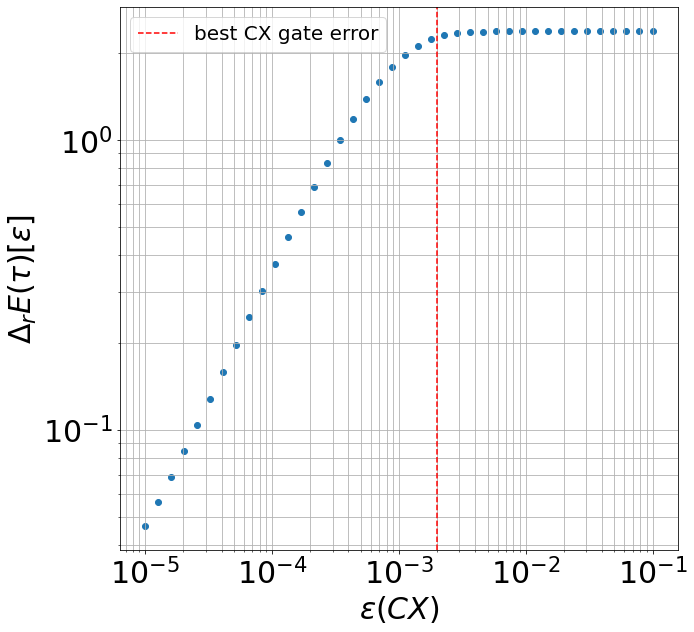

In [43]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))
print(energy[-1],energies_vs_noise[0])
de=np.abs((energies_vs_noise-energy[-1])/energy[-1])
plt.scatter(cx_error_rates,de)

plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$\Delta_r E(\tau)[\epsilon]$',fontsize=30)

plt.show()

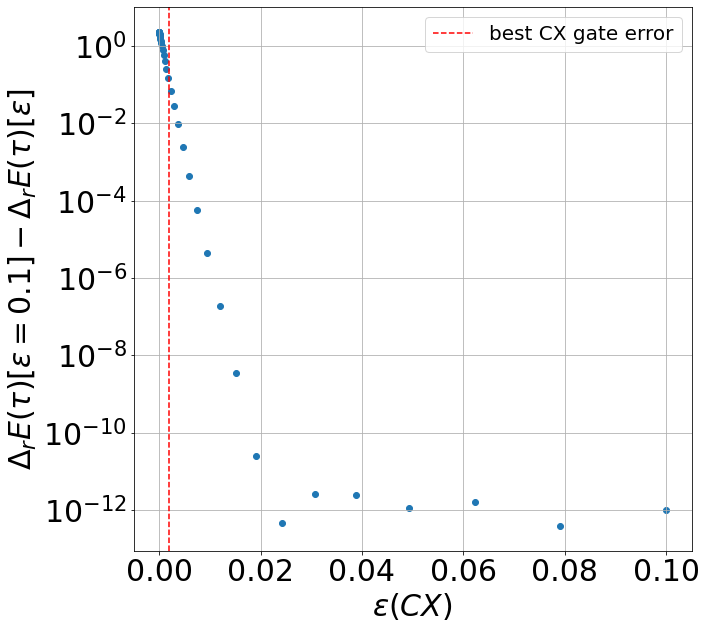

In [44]:
plt.figure(figsize=(10,10))
plt.scatter(cx_error_rates,de[-1]-de+10**-12)

plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
plt.legend(fontsize=20)
plt.semilogy()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$\Delta_r E(\tau)[\epsilon=0.1]-\Delta_r E(\tau)[\epsilon]$',fontsize=30)

plt.show()

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


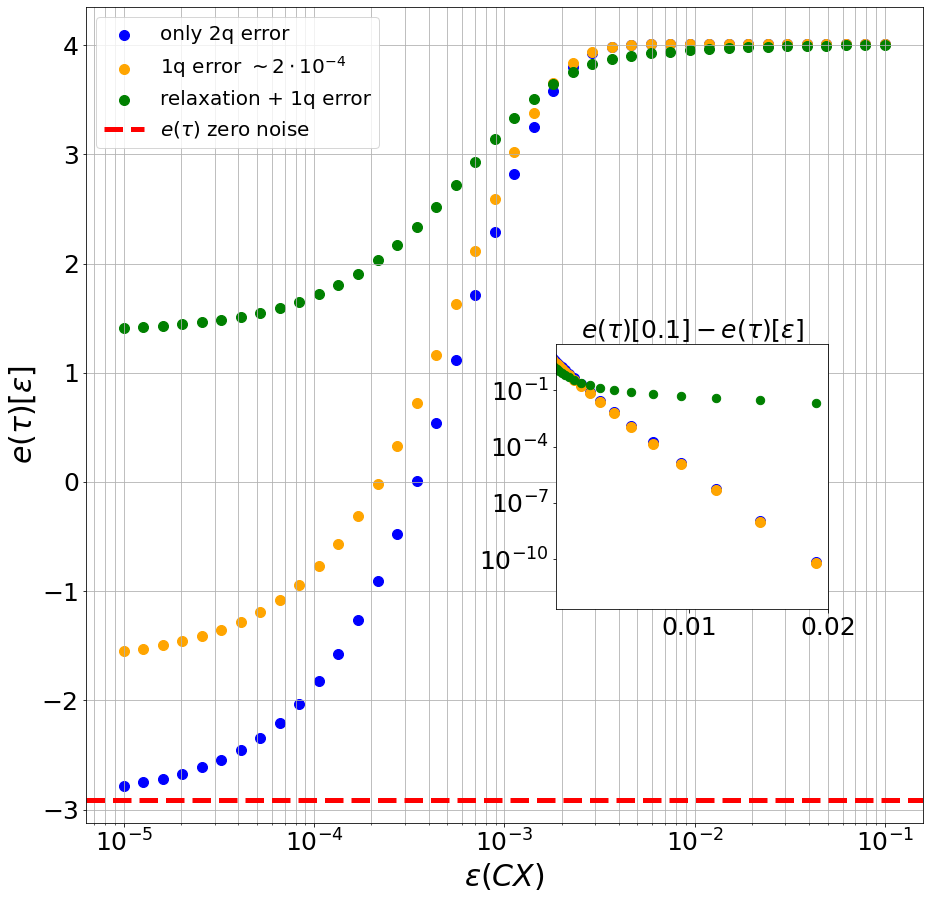

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(15, 15))



# === Main plot: 1 - Fidelity ===
ax.scatter(cx_error_rates, (energies_vs_noise), color='blue' , s=100,label='only 2q error')
ax.scatter(cx_error_rates, (energies_vs_noise_1qerror), color='orange', label='1q error $\sim 2 \cdot 10^{-4}$', s=100)
ax.scatter(cx_error_rates, (energies_vs_noise_dec), color='green', label='relaxation + 1q error', s=100)
#ax.axvline(x=1e-3, color='red', linestyle='--', label='best CX gate error')
#ax.set_xscale('log')
#ax.set_yscale('log')2
#ax.set_xlim([5e-3, 0.02])
ax.semilogx()
ax.set_xlabel(r'$\epsilon(CX)$', fontsize=30)
ax.set_ylabel(r'$e(\tau)[\epsilon]$', fontsize=30)
ax.tick_params(labelsize=25)
ax.tick_params(labelsize=25,which='minor')
ax.axhline(y=(energy[-1]), label=r'$e(\tau)$ zero noise',linestyle='--',color='red',linewidth=5)
ax.grid(True, which='both')
ax.legend(fontsize=20)

# === Inset plot: Fidelity difference ===
ax_inset = inset_axes(
    ax,
    width="65%", height="65%",
    bbox_to_anchor=(0.55, 0.25, 0.5, 0.5),  # (x0, y0, width, height) in axes fraction
    bbox_transform=ax.transAxes,
    loc='lower left', borderpad=1
)

y_diff = np.abs(energies_vs_noise[-1] - energies_vs_noise) + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='blue', s=100)
y_diff = np.abs(energies_vs_noise_1qerror[-1] - energies_vs_noise_1qerror) + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='orange', s=100)
y_diff = np.abs(energies_vs_noise_dec[-1] - energies_vs_noise_dec) + 1e-12
ax_inset.scatter(cx_error_rates, y_diff, color='green', s=70)
# ax_inset.set_xscale('log')
# ax_inset.set_yscale('log')
ax_inset.set_xlim([5e-4, 0.02])
ax_inset.tick_params(labelsize=25)
ax_inset.tick_params(labelsize=25,which='minor')
ax_inset.semilogy()
ax_inset.set_title(r'$  e(\tau)[0.1] -  e(\tau)[\epsilon]$', fontsize=25)
ax_inset.semilogy()

plt.show()

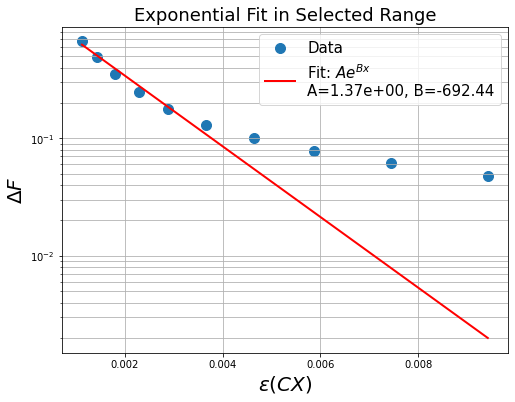

In [50]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Prepare data
x = np.array(cx_error_rates)
y = np.abs(energies_vs_noise_dec[-1] - energies_vs_noise_dec) + 1e-12

# Select range
mask = (x >= 1e-3) & (x <= 1e-2)
x_fit = x[mask]
y_fit = y[mask]

# Define exponential model: y = A * exp(B * x)
def exp_model(x, A, B):
    return A * np.exp(B * x)

# Fit the model
popt, pcov = curve_fit(exp_model, x_fit, y_fit, p0=(1e-3, -100))  # initial guess

A_fit, B_fit = popt

# Generate smooth curve for plotting
x_smooth = np.linspace(min(x_fit), max(x_fit), 300)
y_smooth = exp_model(x_smooth, *popt)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x_fit, y_fit, label='Data', s=100)
plt.plot(x_smooth, y_smooth, label=fr'Fit: $A e^{{B x}}$' + f'\nA={A_fit:.2e}, B={B_fit:.2f}', color='red', linewidth=2)
plt.xlabel(r'$\epsilon(CX)$', fontsize=20)
plt.ylabel(r'$\Delta F$', fontsize=20)
plt.semilogy()
plt.grid(True, which='both')
plt.legend(fontsize=15)
plt.title('Exponential Fit in Selected Range', fontsize=18)
plt.show()

In [51]:
# Predict y values using the fit
y_pred = exp_model(x_fit, *popt)

# Compute R^2
residuals = y_fit - y_pred
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_fit - np.mean(y_fit))**2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R^2 = {r_squared:.10f}")

R^2 = 0.9620611972


In [52]:
print(np.abs( (energies_vs_noise[-1]+A_fit)-energy[-1])/energy[-1])

-2.843179340383388


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


[0.0083213 +2.02690405e-16j 0.01011949+6.39863632e-17j
 0.0123871 -2.12591229e-17j 0.01524347+2.23508232e-16j
 0.01883635+3.78404063e-16j 0.02334751-2.02025184e-16j
 0.02899878+3.11257891e-16j 0.0360579 -2.41860352e-16j
 0.04484348-5.48162033e-16j 0.05572738+5.96589434e-16j
 0.0691322 +1.93470395e-16j 0.08552027+5.49450650e-16j
 0.10536913+5.23225693e-17j 0.1291273 +4.68974933e-16j
 0.15714346+4.30921439e-16j 0.189564  -3.56939909e-16j
 0.2261999 +5.42274864e-16j 0.26637708+6.37439554e-17j
 0.30880662+1.58466907e-16j 0.35153945+5.21765884e-17j
 0.39209129+4.73664257e-17j 0.42781007-3.19816968e-16j
 0.45647529+6.71844630e-18j 0.47696079-3.13001207e-17j
 0.489636  +2.14214246e-16j 0.49619572-9.00556971e-17j
 0.49891714+6.96233380e-17j 0.49977589+4.23665460e-17j
 0.49996893-1.45038018e-16j 0.4999974 -1.31643337e-16j
 0.49999989-1.15178388e-16j 0.5       -3.06162379e-17j
 0.5       +5.07041059e-17j 0.5       -4.26236381e-18j
 0.5       +4.88852728e-17j 0.5       -3.03839536e-17j
 0.5      

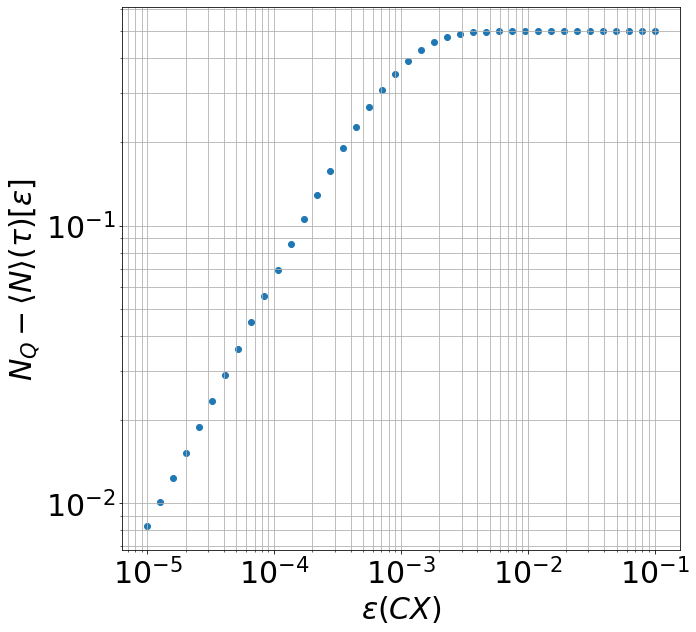

In [53]:
#plt.plot(cx_error_rates,infidelity[-1]-infidelity)
plt.figure(figsize=(10,10))

plt.scatter(cx_error_rates,conservation_check)
print(conservation_check)
#plt.axvline(x=2*10**-3,color='red',linestyle='--',label='best CX gate error')
#plt.legend(fontsize=20)
plt.loglog()
plt.grid(which='minor')
plt.grid(which='major')
plt.tick_params(labelsize=30)
plt.xlabel(r'$\epsilon(CX)$',fontsize=30)
plt.ylabel(r'$N_Q- \langle N \rangle (\tau)[\epsilon]$',fontsize=30)

plt.show()

#### Extrapolate the error

In [54]:

#final_state=Statevector(circuit_opt)
time_steps=20
tf=2
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    for a in range(n_qubits):
        a_mb=2**(a)
        final_state=Statevector(circuit_time_evolution).data
        single_particle_vector[a_mb]=final_state[a_mb]
        psi_for_fidelity[a]=final_state[a_mb]
    energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
final_state=Statevector(circuit_time_evolution)

print(final_state.expectation_value(hamiltonian_q))

/tmp/ipykernel_2362206/3721214493.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


(0.05577912244282501+0j)


In [55]:
transpiled_circuit_time_evolution.save_density_matrix()

In [101]:
from qiskit import QuantumCircuit
from copy import deepcopy


def amplify_cnots_qiskit(circuit, cnot_multiples=[0,2, 4, 6]):
    """
    Amplify noise in a Qiskit circuit by repeating each CNOT gate multiple (even) times.
    Returns a list of new circuits with amplified CNOTs.
    """
    amplified_circuits = []

    for m in cnot_multiples:
        new_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)

        for instr, qargs, cargs in circuit.data:
            if instr.name == "cx":
                control = circuit.find_bit(qargs[0]).index
                target = circuit.find_bit(qargs[1]).index
                for _ in range(m + 1):  # original + m times
                    new_circuit.cx(control, target)
            else:
                new_circuit.append(deepcopy(instr), qargs, cargs)

        amplified_circuits.append(new_circuit)

    return amplified_circuits

Noise model

In [102]:
amplified_circuits=amplify_cnots_qiskit(transpiled_circuit_time_evolution)
energies_vs_noise_dec=[]
infidelity_dec=[]
for circuit in amplified_circuits:

    # Create a noise model
    noise_model = NoiseModel()
    t1 = 197 * 10**-6  # 225.54 us to ns
    t2 = 119 * 10**-6  # 183.22 us to ns
    gate_time=68*10**-9
    # Add gate errors
    cx_depol = depolarizing_error(2.68*10**-3, 2)
    rz_depol = depolarizing_error(2e-4, 1)
    #x_depol = depolarizing_error(1e-4, 1)
    h_depol = depolarizing_error(2.024e-4, 1)
    # Add depolarizing errors
    noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
    noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
    #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
    noise_model.add_all_qubit_quantum_error(h_depol, 'h')


    # Add thermal relaxation errors
    thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
    # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

    for gate in ['h', 'rz', 'x']:
        noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
    #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



    sim = AerSimulator(noise_model=noise_model)
    
    # Transpile and run
    tqc = transpile(circuit, sim,optimization_level=0)
    result = sim.run(tqc).result()


    dm = result.data(0)['density_matrix']
    final_state_with_noise=DensityMatrix(dm)
    eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
    n_conservation=final_state_with_noise.expectation_value(n_operator)-1
    f_tau=state_fidelity(final_state_with_noise,final_state)
    print(1-f_tau)
    print(eng_tau,'\n')
    energies_vs_noise_dec.append(eng_tau)
    infidelity_dec.append(1-f_tau)


energies_vs_noise_dec=np.asarray(energies_vs_noise_dec)
infidelity_dec=np.asarray(infidelity_dec)


/tmp/ipykernel_2362206/733115540.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


0.8572507935033483
(3.672879682845866-1.601373765220474e-16j) 



0.8733084813290928
(3.93637425699427+1.0244136311520428e-16j) 



0.8739487151292309
(3.9636727280928157-4.3322294414848995e-17j) 

0.8742213107918675
(3.9754221261115674-5.5761255118892915e-18j) 



/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_2362206/2321697340.py:4: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.semilogy()
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib_inline/backend_inline.py:234: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


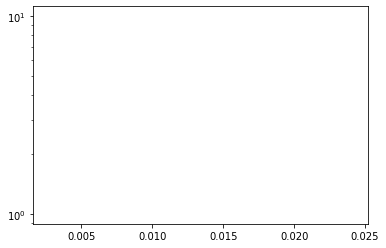

In [58]:
errors=np.array([1,3,5,7,9])*2.68*10**-3

plt.plot(errors,energies_vs_noise_dec-energies_vs_noise_dec[-1])
plt.semilogy()
plt.show()

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


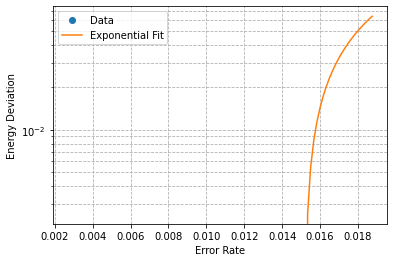

807.5080429979848


In [111]:
import numpy as np
import matplotlib.pyplot as plt

# X-axis: errors (amplification levels)
errors = np.array([1, 3, 5,7]) * 2.68e-3

# Y-axis: energy deviations (your data)
# Replace with your actual energy values
energy_values = np.array(energies_vs_noise_dec)
energy_deviation = energy_values - energy_values[-1]  # subtract asymptotic (lowest noise) energy

from scipy.optimize import curve_fit

# Exponential decay model
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Fit the curve
params, _ = curve_fit(exp_decay, errors, energy_deviation, p0=(1, 1, 0))
a_fit, b_fit, c_fit = params

# Plot original data
plt.plot(errors, energy_deviation, 'o', label='Data')

# Plot fitted exponential
x_fit = np.linspace(min(errors), max(errors), 100)
y_fit = exp_decay(x_fit, a_fit, b_fit, c_fit)
plt.plot(x_fit, y_fit, '-', label='Exponential Fit')

# Log scale for y-axis
plt.semilogy()
plt.xlabel('Error Rate')
plt.ylabel('Energy Deviation')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.show()

print(a_fit)

In [30]:
from scipy.optimize import curve_fit
import numpy as np

# Model and fit
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

params, _ = curve_fit(exp_decay, errors, energy_deviation, p0=(1, 1, 0))
a_fit, b_fit, c_fit = params

# Predicted values
y_pred = exp_decay(errors, a_fit, b_fit, c_fit)

# Actual values
y_true = energy_deviation

# Compute R^2
ss_res = np.sum((y_true - y_pred) ** 2)
ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R² = {r_squared:.4f}")

R² = 0.9984+0.0000j


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


#### ZNE for different $\tau \omega$

In [ ]:
from qiskit import QuantumCircuit
from copy import deepcopy


def amplify_cnots_qiskit(circuit, cnot_multiples=[0,2, 4,6,8 ]):
    """
    Amplify noise in a Qiskit circuit by repeating each CNOT gate multiple (even) times.
    Returns a list of new circuits with amplified CNOTs.
    """
    amplified_circuits = []

    for m in cnot_multiples:
        new_circuit = QuantumCircuit(circuit.num_qubits, circuit.num_clbits)

        for instr, qargs, cargs in circuit.data:
            if instr.name == "cx":
                control = circuit.find_bit(qargs[0]).index
                target = circuit.find_bit(qargs[1]).index
                for _ in range(m + 1):  # original + m times
                    new_circuit.cx(control, target)
            else:
                new_circuit.append(deepcopy(instr), qargs, cargs)

        amplified_circuits.append(new_circuit)

    return amplified_circuits

In [104]:

#final_state=Statevector(circuit_opt)
errors_vs_tf=[]
infidelities_vs_tf=[]
energies_vs_tf=[]
tfs=np.linspace(0.1,10,20)
for tf in tfs:
    time_steps=int(tf*10)
    time=np.linspace(0,tf,time_steps)
    dt=tf/time_steps
    #b=0.8
    #h=1-(1+b)*(time/tf)+b*(time/tf)**2
    h=1-time/tf
    circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
    circuit_time_evolution.x([0]) # initial state

    energies_qiskit=np.zeros((time_steps))


    for n,t in enumerate(time):
        hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
        exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
        #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
        circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
        psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
        for a in range(n_qubits):
            a_mb=2**(a)
            final_state=Statevector(circuit_time_evolution).data
            single_particle_vector[a_mb]=final_state[a_mb]
            psi_for_fidelity[a]=final_state[a_mb]
        energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

    transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
    final_state=Statevector(circuit_time_evolution)

    transpiled_circuit_time_evolution.save_density_matrix()
    print(f'energies ={final_state.expectation_value(hamiltonian_q)} at tau={tf}')

    amplified_circuits=amplify_cnots_qiskit(transpiled_circuit_time_evolution)
    energies_vs_noise_dec=[]
    infidelity_dec=[]
    for m,circuit in enumerate(amplified_circuits):

        # Create a noise model
        noise_model = NoiseModel()
        t1 = 197 * 10**-6  # 225.54 us to ns
        t2 = 119 * 10**-6  # 183.22 us to ns
        gate_time=68*10**-9
        # Add gate errors
        cx_depol = depolarizing_error(2.68*10**-3, 2)
        rz_depol = depolarizing_error(2e-4, 1)
        #x_depol = depolarizing_error(1e-4, 1)
        h_depol = depolarizing_error(2.024e-4, 1)
        
        thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
        
        #cx_depol.compose(thermal_1q)
        rz_depol.compose(thermal_1q)
        h_depol.compose(thermal_1q)
        
        # Add depolarizing errors
        noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
        noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
        #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
        noise_model.add_all_qubit_quantum_error(h_depol, 'h')

        # print(
        #     f"""
        #     amplification:{m}
        #     Nonlocal gate count: {circuit.num_nonlocal_gates()}
        #         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

        # """
        # )
        # Add thermal relaxation errors

        # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

        # for gate in ['h', 'rz', 'x']:
        #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
        # #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



        sim = AerSimulator(noise_model=noise_model)
        
        # Transpile and run
        tqc = transpile(circuit, sim,optimization_level=0)
        result = sim.run(tqc).result()


        dm = result.data(0)['density_matrix']
        final_state_with_noise=DensityMatrix(dm)
        eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
        n_conservation=final_state_with_noise.expectation_value(n_operator)-1
        f_tau=state_fidelity(final_state_with_noise,final_state)
        #print(1-f_tau)
        #print(eng_tau,'\n')
        energies_vs_noise_dec.append(eng_tau)
        infidelity_dec.append(1-f_tau)

    print(f'energies with noise={energies_vs_noise_dec[0]} 1-f with noise={infidelity_dec[0]} \n')
    energies_vs_noise_dec=np.asarray(energies_vs_noise_dec)
    infidelity_dec=np.asarray(infidelity_dec)
    
    errors_vs_tf.append(energies_vs_noise_dec)
    infidelities_vs_tf.append(infidelity_dec)
    energies_vs_tf.append(final_state.expectation_value(hamiltonian_q))
    
errors_vs_tf=np.asarray(errors_vs_tf)
infidelities_vs_tf=np.asarray(infidelities_vs_tf)
energies_vs_tf=np.asarray(energies_vs_tf)

/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(1.5678999999999998+0j) at tau=0.1
energies with noise=(1.567112603571268+0j) 1-f with noise=0.0005021981176936974 

energies =(1.825963639357905+0j) at tau=0.6210526315789474


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(2.079827513549159+1.6610055991428072e-16j) 1-f with noise=0.13156644236721127 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.47148269246195484+0j) at tau=1.142105263157895


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(1.3397919158695917+1.4147638888603548e-16j) 1-f with noise=0.24382288891962212 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.22947703918936257+0j) at tau=1.6631578947368424


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(1.5376435803784498-3.1468977526816053e-16j) 1-f with noise=0.3401619752894043 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-0.44618476921378836+0j) at tau=2.18421052631579


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(1.5381566427145348-2.976187205976876e-16j) 1-f with noise=0.422697309351285 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-0.5120778410064499+0j) at tau=2.7052631578947373


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(1.8932693201817452-2.0023117326301394e-16j) 1-f with noise=0.5049217898590093 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-0.9111302669277279+0j) at tau=3.2263157894736847


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(2.059934742614496+1.5110602076491075e-16j) 1-f with noise=0.5630342779654636 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-1.1040563944098585+0j) at tau=3.747368421052632


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(2.254962004999291-4.497356299773138e-17j) 1-f with noise=0.6115475103127652 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-1.3878210673598907+0j) at tau=4.268421052631579


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(2.4449851380116954-2.7157982527157104e-16j) 1-f with noise=0.6534387585427455 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-1.5015974340722966+0j) at tau=4.7894736842105265


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(2.6239596053745613-1.163604236004452e-16j) 1-f with noise=0.6881698111696821 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-1.678951461688599+0j) at tau=5.310526315789474


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(2.8346352186472736-7.92681954852025e-17j) 1-f with noise=0.7230440210940655 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-1.8227977619649316+0j) at tau=5.831578947368421


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(2.966398945934661-1.843933697497567e-16j) 1-f with noise=0.7469630930875433 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-1.9675584522087401+0j) at tau=6.352631578947369


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(3.104736800115934+2.921234650922292e-16j) 1-f with noise=0.7673832452643298 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-2.0744688073981683+0j) at tau=6.873684210526316


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(3.2118103107076665-3.092505177957469e-17j) 1-f with noise=0.7843437701306006 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-2.147799478210901+0j) at tau=7.394736842105264


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(3.3234807345239212-6.895577623550759e-16j) 1-f with noise=0.7986889491015158 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-2.2563324587114337+0j) at tau=7.915789473684211


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(3.4228906405742467+3.1829349073037047e-16j) 1-f with noise=0.8128114831655543 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-2.3375074919081413+0j) at tau=8.436842105263159


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(3.503535386683769-2.115053514967295e-16j) 1-f with noise=0.8226274879885742 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-2.4015524652195746+0j) at tau=8.957894736842105


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(3.5670572787276487-7.278143957843922e-17j) 1-f with noise=0.8308638905811949 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-2.469164626897385+0j) at tau=9.478947368421053


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(3.627618791986497-3.105830207548401e-16j) 1-f with noise=0.8377724171463401 



/tmp/ipykernel_2362206/3209369493.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(-2.490981015655316+0j) at tau=10.0


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


energies with noise=(3.686723410510771+5.45995972693322e-16j) 1-f with noise=0.8446156215952773 



In [93]:
print(errors_vs_tf)

[[1.5671126 +0.00000000e+00j 1.5671126 +0.00000000e+00j
  1.5671126 +0.00000000e+00j]
 [2.07982751+1.66100560e-16j 2.46698162-9.69053976e-17j
  2.77533876-1.31402872e-16j]
 [1.33979192+1.41476389e-16j 2.39956526-1.43839765e-16j
  3.03321314+8.22160983e-17j]
 [1.53764358-3.14689775e-16j 2.85271035+2.92411598e-16j
  3.46056017-5.41214534e-17j]
 [1.53815664-2.97618721e-16j 3.14243991-1.40351315e-16j
  3.69683333+1.05568483e-16j]
 [1.89326932-2.00231173e-16j 3.45715625-1.02514698e-16j
  3.85861407+1.11701453e-16j]
 [2.05993474+1.51106021e-16j 3.62635318-1.51126496e-16j
  3.92841718+4.64762638e-17j]
 [2.254962  -4.49735630e-17j 3.74023092+1.34916469e-17j
  3.96373186+3.18730035e-19j]
 [2.44498514-2.71579825e-16j 3.82787191+1.53454003e-16j
  3.98473579+7.79399877e-17j]
 [2.62395961-1.16360424e-16j 3.88303119+1.27658222e-16j
  3.99504518+3.94909862e-17j]
 [2.83463522-7.92681955e-17j 3.93101141-1.99241962e-16j
  4.00182597+5.95203086e-17j]
 [2.96639895-1.84393370e-16j 3.95440012-1.07076700e-16

In [84]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_circuit_time_evolution.depth()}
             Gate count: {len(transpiled_circuit_time_evolution)}
    Nonlocal gate count: {transpiled_circuit_time_evolution.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_circuit_time_evolution.count_ops().items()])}

"""
)



# And finall
%matplotlib inline
#initial_state.draw("text")


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 2381
             Gate count: 3570
    Nonlocal gate count: 1188
         Gate breakdown: RZ: 1190, H: 1190, CX: 1188, S: 1, SAVE_DENSITY_MATRIX: 1




Analysis

(20, 4)
[2.07982751+1.66100560e-16j 2.46698162-9.69053976e-17j
 2.77533876-1.31402872e-16j 3.02119795-1.09391273e-16j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


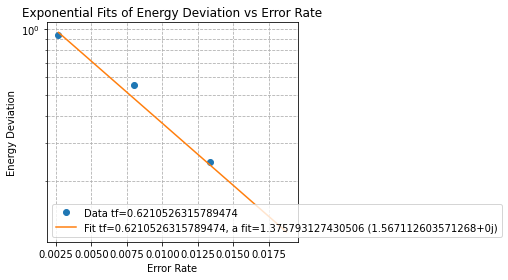

R² = 0.9592-0.0000j
[1.33979192+1.41476389e-16j 2.39956526-1.43839765e-16j
 3.03321314+8.22160983e-17j 3.41408691-6.02428989e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


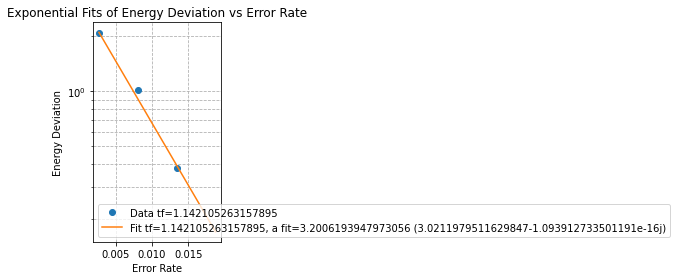

R² = 0.9834-0.0000j
[1.53764358-3.14689775e-16j 2.85271035+2.92411598e-16j
 3.46056017-5.41214534e-17j 3.74533021-1.00067971e-16j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


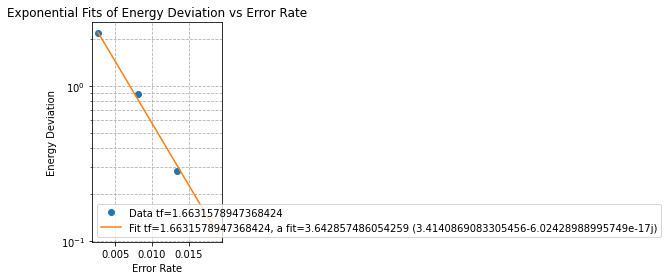

R² = 0.9937+0.0000j
[1.53815664-2.97618721e-16j 3.14243991-1.40351315e-16j
 3.69683333+1.05568483e-16j 3.89326602-6.02169040e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


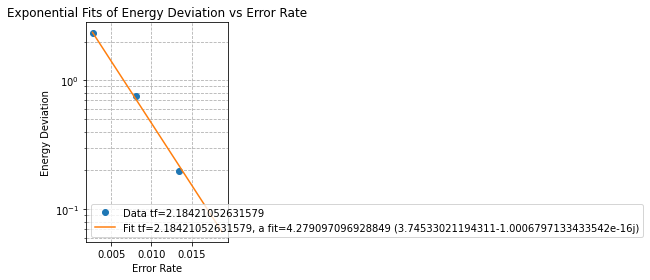

R² = 0.9982-0.0000j
[1.89326932-2.00231173e-16j 3.45715625-1.02514698e-16j
 3.85861407+1.11701453e-16j 3.96586686-5.61309151e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


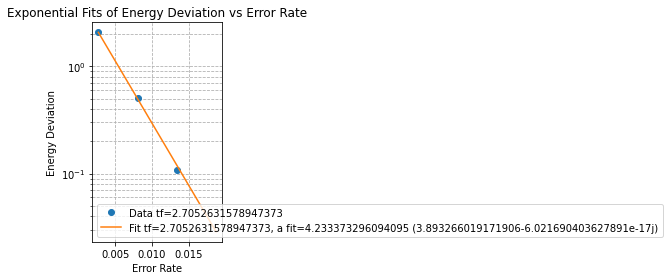

R² = 0.9996-0.0000j
[2.05993474+1.51106021e-16j 3.62635318-1.51126496e-16j
 3.92841718+4.64762638e-17j 3.99029329-3.42490453e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


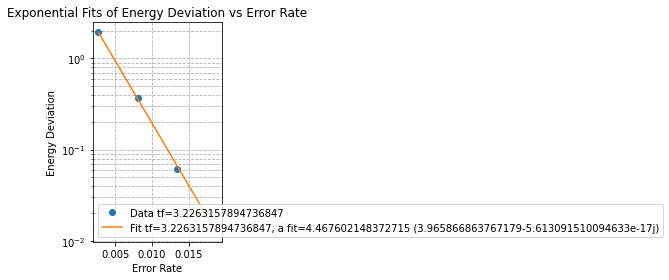

R² = 0.9999-0.0000j
[2.254962  -4.49735630e-17j 3.74023092+1.34916469e-17j
 3.96373186+3.18730035e-19j 4.00000492+2.11024204e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


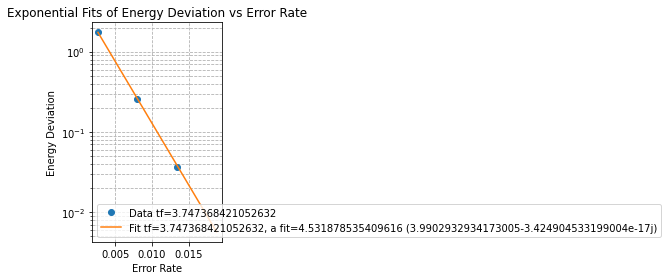

R² = 1.0000+0.0000j
[2.44498514-2.71579825e-16j 3.82787191+1.53454003e-16j
 3.98473579+7.79399877e-17j 4.00451929-2.29304993e-18j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


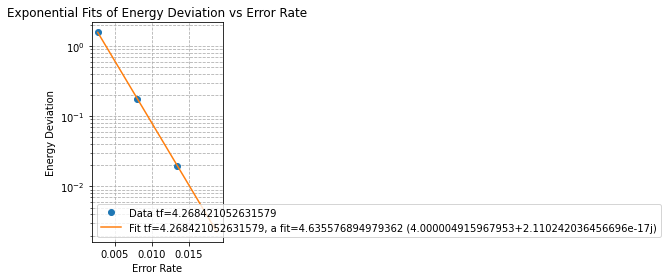

R² = 1.0000+0.0000j
[2.62395961-1.16360424e-16j 3.88303119+1.27658222e-16j
 3.99504518+3.94909862e-17j 4.0063158 +5.23475024e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


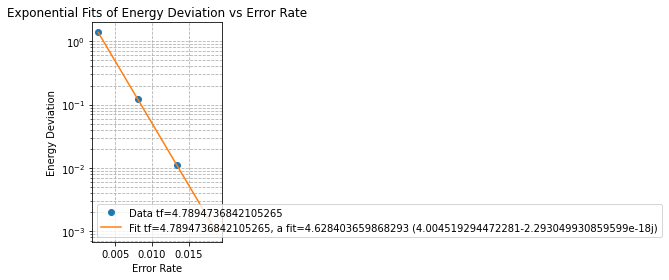

R² = 1.0000-0.0000j
[2.83463522-7.92681955e-17j 3.93101141-1.99241962e-16j
 4.00182597+5.95203086e-17j 4.00722916+1.22394084e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


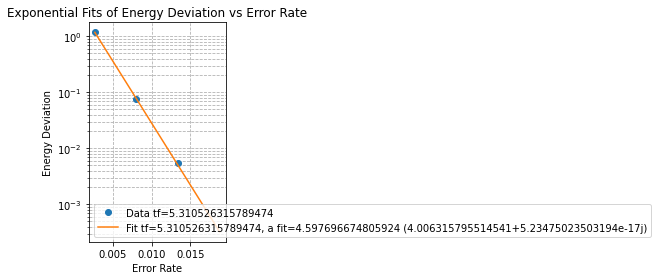

R² = 1.0000+0.0000j
[2.96639895-1.84393370e-16j 3.95440012-1.07076700e-16j
 4.00446275-4.63348541e-18j 4.00751721+5.44852048e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


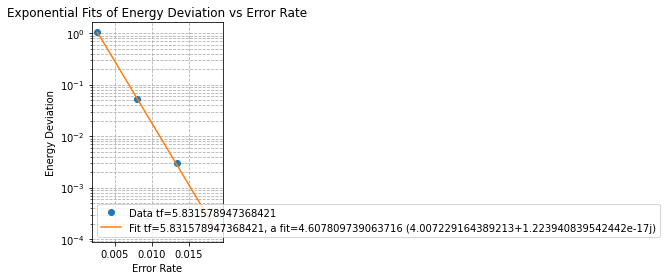

R² = 1.0000-0.0000j
[3.1047368 +2.92123465e-16j 3.97223533+1.05788527e-16j
 4.00599766-5.23644763e-17j 4.00764873+2.36698475e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


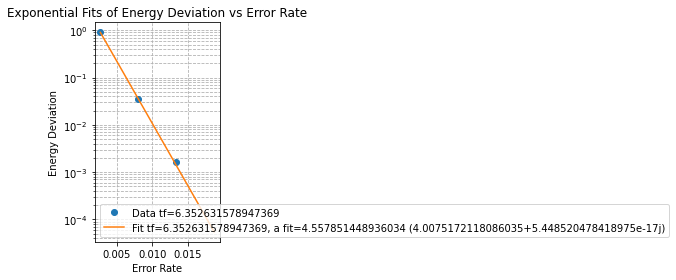

R² = 1.0000-0.0000j
[3.21181031-3.09250518e-17j 3.98315684-5.42699313e-17j
 4.00677733-5.72872255e-17j 4.00770464+2.42529327e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


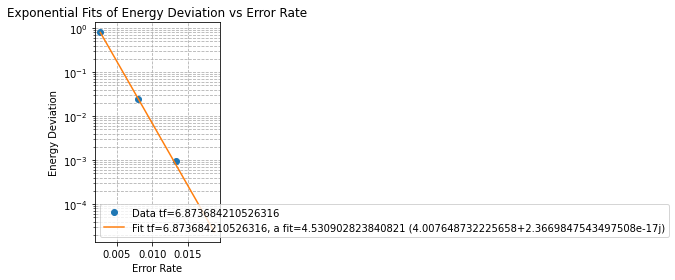

R² = 1.0000-0.0000j
[3.32348073-6.89557762e-16j 3.99132094-7.60739241e-17j
 4.00722422-6.39327661e-17j 4.00772996-1.40734515e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


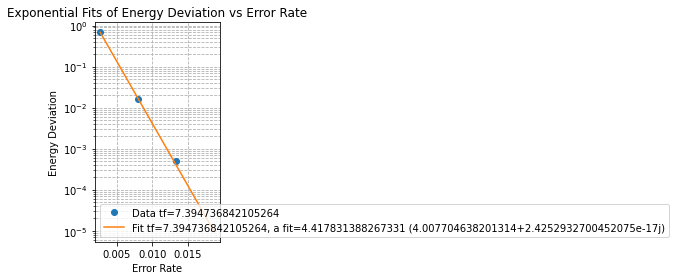

R² = 1.0000-0.0000j
[3.42289064+3.18293491e-16j 3.99718774-3.37068019e-18j
 4.00748875-4.81855573e-20j 4.00774227+5.07425816e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


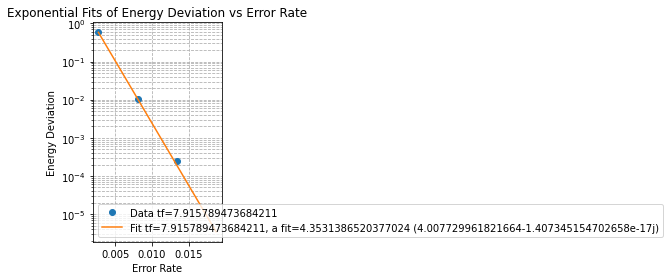

R² = 1.0000-0.0000j
[3.50353539-2.11505351e-16j 4.0006204 -1.49639368e-16j
 4.00760673-7.21901220e-18j 4.00774655-1.02644211e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


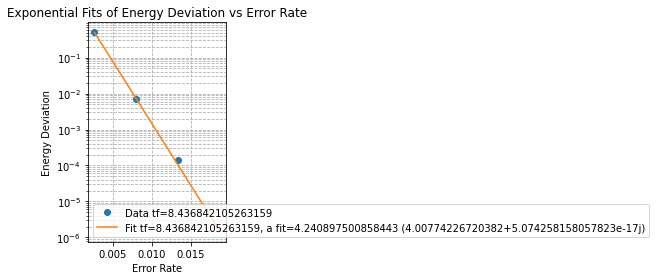

R² = 1.0000+0.0000j
[3.56705728-7.27814396e-17j 4.00282223-1.33824780e-16j
 4.00767012-5.87991566e-17j 4.00774844+2.58180438e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


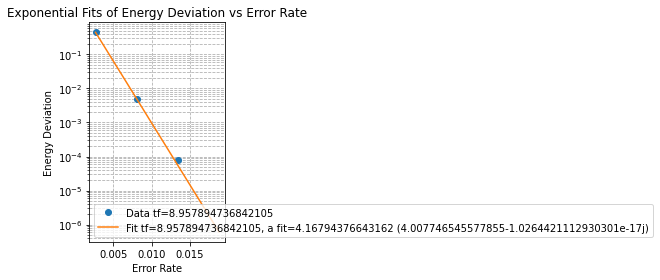

R² = 1.0000-0.0000j
[3.62761879-3.10583021e-16j 4.00439735-8.93518965e-17j
 4.00770579+7.09735100e-17j 4.0077493 +6.03972117e-17j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


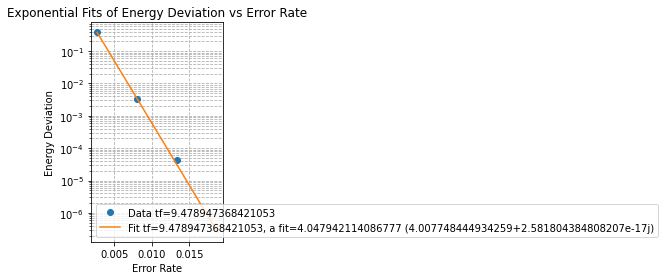

R² = 1.0000+0.0000j
[3.68672341+5.45995973e-16j 4.00559354-9.78033147e-18j
 4.00772787+3.46269429e-17j 4.00774973-6.34566052e-18j]


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


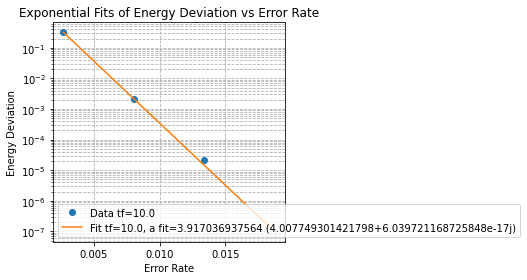

R² = 1.0000+0.0000j
a_fit values for each tf:
[1.37579313 3.20061939 3.64285749 4.2790971  4.2333733  4.46760215
 4.53187854 4.63557689 4.62840366 4.59769667 4.60780974 4.55785145
 4.53090282 4.41783139 4.35313865 4.2408975  4.16794377 4.04794211
 3.91703694]


In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example setup — replace with your actual data
errors = np.array([1, 3, 5,7]) * 2.68e-3  # [num_noise_levels]


# Define exponential decay model
def exp_decay(x, a, b):
    return a * np.exp(-b * x) 

# To store fitted parameters
fit_params = []


print(errors_vs_tf.shape)
shift_values=[]
for i, energy_values in enumerate(errors_vs_tf[1:]):
    print(energy_values)
    energy_deviation = energy_values[-1]-energy_values

    try:
        params, _ = curve_fit(exp_decay, errors, energy_deviation, p0=(1, 1))
        a_fit, b_fit = params
        fit_params.append(params)

        # Plot
        x_fit = np.linspace(min(errors), max(errors), 100)
        y_fit = exp_decay(x_fit, a_fit, b_fit)
        plt.plot(errors, energy_deviation, 'o', label=f'Data tf={tfs[i+1]}')
        plt.plot(x_fit, y_fit, '-', label=f'Fit tf={tfs[i+1]}, a fit={a_fit} {errors_vs_tf[i,-1]}')
        # Final plot settings
        plt.semilogy()
        plt.xlabel("Error Rate")
        plt.ylabel("Energy Deviation")
        plt.legend()
        plt.grid(True, which='both', ls='--')
        plt.title("Exponential Fits of Energy Deviation vs Error Rate")
        plt.tight_layout()
        plt.show()
    
    except RuntimeError:
        print(f"Fit failed for tf index {i}")
        fit_params.append((np.nan, np.nan, np.nan))
    shift_values.append(a_fit)
    


    # Predicted values
    y_pred = exp_decay(errors, a_fit, b_fit)

    # Actual values
    y_true = energy_deviation

    # Compute R^2
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"R² = {r_squared:.4f}")
    


# Convert parameters to NumPy array for further use
fit_params = np.array(fit_params)

# Optional: Print just the a_fit parameters
print("a_fit values for each tf:")
print(fit_params[:, 0])

In [107]:
energy_zne_vs_tf=[]
tfs_zne=[]
for i in range(1,tfs.shape[0]):
    tfs_zne.append(tfs[i])
    print(errors_vs_tf[i])
    print('estimation=',errors_vs_tf[i,-1]-shift_values[i-1],shift_values[i-1],'exact=',energies_vs_tf[i],'without zne=',errors_vs_tf[i,-1],'tf=',tfs[i],'\n')
    energy_zne_vs_tf.append(errors_vs_tf[i,-1]-shift_values[i-1])
    

[2.07982751+1.66100560e-16j 2.46698162-9.69053976e-17j
 2.77533876-1.31402872e-16j 3.02119795-1.09391273e-16j]
estimation= (1.6454048237324788-1.093912733501191e-16j) 1.375793127430506 exact= (1.825963639357905+0j) without zne= (3.0211979511629847-1.093912733501191e-16j) tf= 0.6210526315789474 

[1.33979192+1.41476389e-16j 2.39956526-1.43839765e-16j
 3.03321314+8.22160983e-17j 3.41408691-6.02428989e-17j]
estimation= (0.21346751353324-6.02428988995749e-17j) 3.2006193947973056 exact= (0.47148269246195484+0j) without zne= (3.4140869083305456-6.02428988995749e-17j) tf= 1.142105263157895 

[1.53764358-3.14689775e-16j 2.85271035+2.92411598e-16j
 3.46056017-5.41214534e-17j 3.74533021-1.00067971e-16j]
estimation= (0.10247272588885137-1.0006797133433542e-16j) 3.642857486054259 exact= (0.22947703918936257+0j) without zne= (3.74533021194311-1.0006797133433542e-16j) tf= 1.6631578947368424 

[1.53815664-2.97618721e-16j 3.14243991-1.40351315e-16j
 3.69683333+1.05568483e-16j 3.89326602-6.02169040e-17

Plot of the QA protocol at different $\tau \omega$ with ZNE and without

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


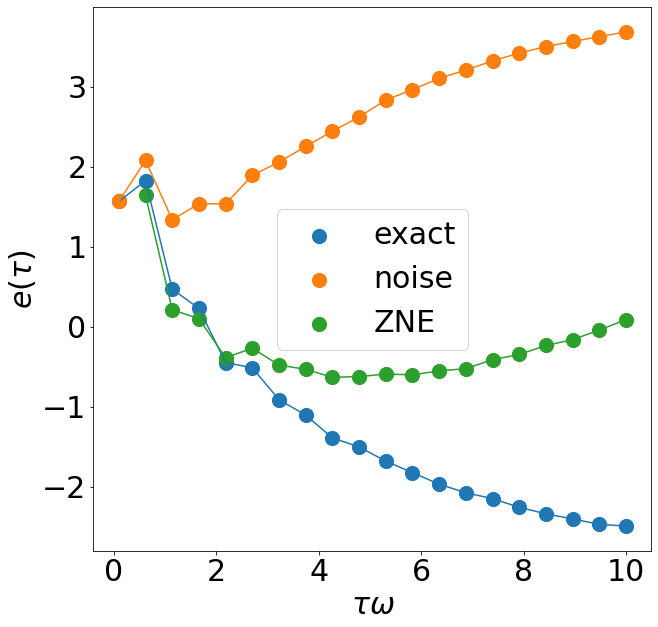

In [108]:
plt.figure(figsize=(10,10))
plt.plot(tfs,energies_vs_tf)
plt.scatter(tfs,energies_vs_tf,s=200,label='exact')
plt.plot(tfs,errors_vs_tf[:,0])
plt.scatter(tfs,errors_vs_tf[:,0],s=200,label='noise')
plt.plot(tfs_zne,energy_zne_vs_tf)
plt.scatter(tfs_zne,energy_zne_vs_tf,s=200,label='ZNE')
plt.tick_params(which='major',labelsize=30)
plt.legend(fontsize=30)
plt.xlabel(r'$\tau \omega$',fontsize=30)
plt.ylabel(r'$e(\tau)$',fontsize=30)
plt.show()

#### ZNE for the number of particles

In [109]:

#final_state=Statevector(circuit_opt)
n_errors_vs_tf=[]
infidelities_vs_tf=[]
n_vs_tf=[]
tfs=np.linspace(0.1,10,20)
for tf in tfs:
    time_steps=int(tf*10)
    time=np.linspace(0,tf,time_steps)
    dt=tf/time_steps
    #b=0.8
    #h=1-(1+b)*(time/tf)+b*(time/tf)**2
    h=1-time/tf
    circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits)
    circuit_time_evolution.x([0]) # initial state

    energies_qiskit=np.zeros((time_steps))


    for n,t in enumerate(time):
        hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
        exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
        #exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=QDrift(reps=5))
        circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
        psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
        for a in range(n_qubits):
            a_mb=2**(a)
            final_state=Statevector(circuit_time_evolution).data
            single_particle_vector[a_mb]=final_state[a_mb]
            psi_for_fidelity[a]=final_state[a_mb]
        energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)

    transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])
    final_state=Statevector(circuit_time_evolution)

    transpiled_circuit_time_evolution.save_density_matrix()
    print(f'energies ={final_state.expectation_value(n_operator)-1} at tau={tf}')

    amplified_circuits=amplify_cnots_qiskit(transpiled_circuit_time_evolution)
    n_vs_noise_dec=[]
    infidelity_dec=[]
    for m,circuit in enumerate(amplified_circuits):

        # Create a noise model
        noise_model = NoiseModel()
        t1 = 197 * 10**-6  # 225.54 us to ns
        t2 = 119 * 10**-6  # 183.22 us to ns
        gate_time=68*10**-9
        # Add gate errors
        cx_depol = depolarizing_error(2.68*10**-3, 2)
        rz_depol = depolarizing_error(2e-4, 1)
        #x_depol = depolarizing_error(1e-4, 1)
        h_depol = depolarizing_error(2.024e-4, 1)
        
        thermal_1q = thermal_relaxation_error(t1, t2, gate_time)
        
        #cx_depol.compose(thermal_1q)
        rz_depol.compose(thermal_1q)
        h_depol.compose(thermal_1q)
        
        # Add depolarizing errors
        noise_model.add_all_qubit_quantum_error(cx_depol, 'cx')
        noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
        #noise_model.add_all_qubit_quantum_error(x_depol, 'x')
        noise_model.add_all_qubit_quantum_error(h_depol, 'h')

        # print(
        #     f"""
        #     amplification:{m}
        #     Nonlocal gate count: {circuit.num_nonlocal_gates()}
        #         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

        # """
        # )
        # Add thermal relaxation errors

        # thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

        # for gate in ['h', 'rz', 'x']:
        #     noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
        # #trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')



        sim = AerSimulator(noise_model=noise_model)
        
        # Transpile and run
        tqc = transpile(circuit, sim,optimization_level=0)
        result = sim.run(tqc).result()


        dm = result.data(0)['density_matrix']
        final_state_with_noise=DensityMatrix(dm)
        eng_tau=final_state_with_noise.expectation_value(hamiltonian_q)
        n_conservation=final_state_with_noise.expectation_value(n_operator)-1
        f_tau=state_fidelity(final_state_with_noise,final_state)
        #print(1-f_tau)
        #print(eng_tau,'\n')
        n_vs_noise_dec.append(n_conservation)
        infidelity_dec.append(1-f_tau)

    print(f'n with noise={n_vs_noise_dec[0]} 1-f with noise={infidelity_dec[0]} \n')
    n_vs_noise_dec=np.asarray(n_vs_noise_dec)
    infidelity_dec=np.asarray(infidelity_dec)
    
    n_errors_vs_tf.append(n_vs_noise_dec)
    infidelities_vs_tf.append(infidelity_dec)
    n_vs_tf.append(final_state.expectation_value(n_operator)-1)
    
n_errors_vs_tf=np.asarray(n_errors_vs_tf)
infidelities_vs_tf=np.asarray(infidelities_vs_tf)
n_vs_tf=np.asarray(n_vs_tf)

/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:
/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =0j at tau=0.1
n with noise=(-0.0005021981176935864+0j) 1-f with noise=0.0005021981176936974 

energies =(0.015890666002113862+0j) at tau=0.6210526315789474


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.06616635631853773+6.216726089986179e-17j) 1-f with noise=0.13156644236721127 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.012669330897381537+0j) at tau=1.142105263157895


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.113055553790959+5.295105316675273e-17j) 1-f with noise=0.24382288891962212 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.016177165439332564+0j) at tau=1.6631578947368424


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.1607570280703623-1.1778046607254466e-16j) 1-f with noise=0.3401619752894043 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.024600407994733287+0j) at tau=2.18421052631579


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.20740899018993142-1.1139119977456964e-16j) 1-f with noise=0.422697309351285 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.012442183605712032+0j) at tau=2.7052631578947373


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.24209527044197077-7.494149083513716e-17j) 1-f with noise=0.5049217898590093 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.0285794013068712+0j) at tau=3.2263157894736847


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.28040542487185327+5.655518212148116e-17j) 1-f with noise=0.5630342779654636 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.009424874928707583+0j) at tau=3.747368421052632


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.3024378292537264-1.6832473207310106e-17j) 1-f with noise=0.6115475103127652 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.029765593306655624+0j) at tau=4.268421052631579


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.3341997147555824-1.0164549632770422e-16j) 1-f with noise=0.6534387585427455 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.007278153829886946+0j) at tau=4.7894736842105265


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.3504363583432597-4.355077921543704e-17j) 1-f with noise=0.6881698111696821 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.028826205745009936+0j) at tau=5.310526315789474


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.3764502020758491-2.966809137990238e-17j) 1-f with noise=0.7230440210940655 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.006286344317077308+0j) at tau=5.831578947368421


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.3889359267692667-6.901379941978294e-17j) 1-f with noise=0.7469630930875433 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.02984639338928119+0j) at tau=6.352631578947369


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.4065065585725789+1.093344638858072e-16j) 1-f with noise=0.7673832452643298 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.005612316043481336+0j) at tau=6.873684210526316


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.4158309139110892-1.1574468883877996e-17j) 1-f with noise=0.7843437701306006 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.03139690426866881+0j) at tau=7.394736842105264


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.4288110481742131-2.5808412289504433e-16j) 1-f with noise=0.7986889491015158 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.004194061100802893+0j) at tau=7.915789473684211


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.43710667780477763+1.1912924610955169e-16j) 1-f with noise=0.8128114831655543 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.030171606626749004+0j) at tau=8.436842105263159


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.4467013923036993-7.916113211779534e-17j) 1-f with noise=0.8226274879885742 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.002516820260474839+0j) at tau=8.957894736842105


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.45206057458147164-2.7240261834610154e-17j) 1-f with noise=0.8308638905811949 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.027110493202198604+0j) at tau=9.478947368421053


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.45910012077538687-1.162434111739156e-16j) 1-f with noise=0.8377724171463401 



/tmp/ipykernel_2362206/1159871534.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)


energies =(0.001522021834335252+0j) at tau=10.0


/tmp/ipykernel_2362206/1423134232.py:15: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 2.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


n with noise=(0.4640901431783513+2.043525566814255e-16j) 1-f with noise=0.8446156215952773 



Analysis

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example setup — replace with your actual data
errors = np.array([1, 3, 5, 7, 9]) * 2.68e-3  # [num_noise_levels]

print(n_errors_vs_tf.shape)
# Define exponential decay model
def exp_decay(x, a, b):
    return a * np.exp(-b * x) 

# To store fitted parameters
fit_params = []


print(n_errors_vs_tf.shape)

print(n_errors_vs_tf[3])
shift_values=[]
for i, n_values in enumerate(n_errors_vs_tf[1:]):
    print(n_values)
    n_deviation = n_values[-1]-n_values
    print(n_deviation.shape)
    try:
        params, _ = curve_fit(exp_decay, errors, n_deviation, p0=(1, 1))
        a_fit, b_fit = params
        fit_params.append(params)

        # Plot
        x_fit = np.linspace(min(errors), max(errors), 100)
        y_fit = exp_decay(x_fit, a_fit, b_fit)
        plt.plot(errors, n_deviation, 'o', label=f'Data tf={tfs[i+1]}')
        plt.plot(x_fit, y_fit, '-', label=f'Fit tf={tfs[i+1]}')
        # Final plot settings
        plt.semilogy()
        plt.xlabel("Error Rate")
        plt.ylabel("Energy Deviation")
        plt.legend()
        plt.grid(True, which='both', ls='--')
        plt.title("Exponential Fits of Energy Deviation vs Error Rate")
        plt.tight_layout()
        plt.show()
    
    except RuntimeError:
        print(f"Fit failed for tf index {i}")
        fit_params.append((np.nan, np.nan, np.nan))
    shift_values.append(a_fit)
    


    # Predicted values
    y_pred = exp_decay(errors, a_fit, b_fit)

    # Actual values
    y_true = n_deviation

    # Compute R^2
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"R² = {r_squared:.4f}")
    


# Convert parameters to NumPy array for further use
fit_params = np.array(fit_params)

# Optional: Print just the a_fit parameters
print("a_fit values for each tf:")
print(fit_params[:, 0])

(20, 4)
(20, 4)
[0.16075703-1.17780466e-16j 0.32237081+1.09442305e-16j
 0.40672967-2.02562984e-17j 0.45092748-3.74529242e-17j]
[0.06616636+6.21672609e-17j 0.14556481-3.62692524e-17j
 0.21071827-4.91807894e-17j 0.26410678-4.09424016e-17j]
(4,)


/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/numpy/lib/function_base.py:628: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


ValueError: operands could not be broadcast together with shapes (5,) (4,) 

In [ ]:
n_zne_vs_tf=[]
tfs_zne=[]
for i in range(1,tfs.shape[0]):
    tfs_zne.append(tfs[i])
    print(n_errors_vs_tf[i])
    print('estimation=',n_errors_vs_tf[i,-1]-shift_values[i-1],'exact=',n_vs_tf[i],'without zne=',n_errors_vs_tf[i,-1],'tf=',tfs[i],'\n')
    n_zne_vs_tf.append(n_errors_vs_tf[i,-1]-shift_values[i-1])
    

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


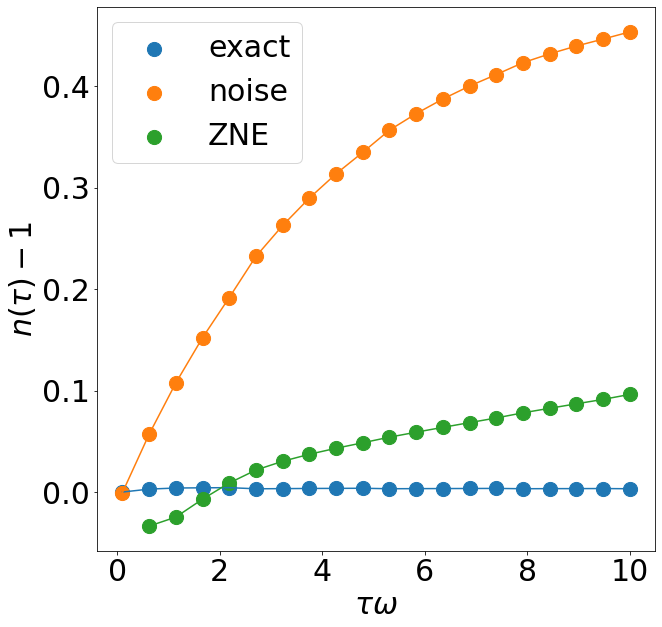

In [88]:
plt.figure(figsize=(10,10))
plt.plot(tfs,n_vs_tf)
plt.scatter(tfs,n_vs_tf,s=200,label='exact')
plt.plot(tfs,n_errors_vs_tf[:,0])
plt.scatter(tfs,n_errors_vs_tf[:,0],s=200,label='noise')
plt.plot(tfs_zne,n_zne_vs_tf)
plt.scatter(tfs_zne,n_zne_vs_tf,s=200,label='ZNE')
plt.tick_params(which='major',labelsize=30)
plt.legend(fontsize=30)
plt.xlabel(r'$\tau \omega$',fontsize=30)
plt.ylabel(r'$n(\tau)-1$',fontsize=30)
plt.show()

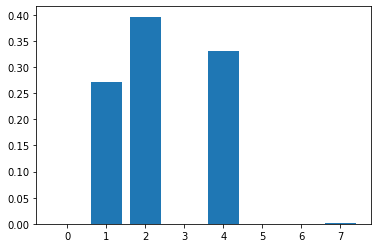

(8,)
(8,)
(8,)


In [30]:
import matplotlib.pyplot as plt



prob=final_state.probabilities()

plt.bar(np.arange(prob.shape[0]),prob)
plt.show()

# convert into the single particle state
single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)

for a in range(n_qubits):
    a_mb=2**(a)
    print(final_state.data.shape)
    single_particle_vector[a_mb]=final_state.data[a_mb]
single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
final_state_clean_single_particle=Statevector(single_particle_vector)

In [32]:
print(np.linalg.norm(single_particle_vector))
print(np.linalg.norm(final_state.data))
print(final_state.expectation_value(hamiltonian_q))

1.0
0.9999999999999992
(-31.291812300918675+0j)


In [21]:
from qiskit import transpile

# Define your basis gates
custom_basis_gates = ['cz', 'id', 'rz', 'sx', 'x']

# Transpile your circuit using those gates
transpiled_initial_state = transpile(
    initial_state,  # your circuit here
    basis_gates=custom_basis_gates,
    optimization_level=3  # or 0–3 depending on your needs
)

In [ ]:
transpiled_initial_state.draw()

In [166]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {transpiled_initial_state.depth()}
             Gate count: {len(transpiled_initial_state)}
    Nonlocal gate count: {transpiled_initial_state.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in transpiled_initial_state.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 427
             Gate count: 709
    Nonlocal gate count: 108
         Gate breakdown: RZ: 272, SX: 264, CZ: 108, X: 65




#### NOISE MODELS

#### Ionq simulator

In [ ]:
import os
from qiskit_ionq import IonQProvider


provider = IonQProvider(token="iNarGLptgimgFldYpwMY5x8mTxRZE1C2")
print(provider.backends())

simulator_backend = provider.get_backend("simulator")
simulator_backend.set_options(noise_model="aria-1")

# Create a basic Bell State circuit:


result = simulator_backend.run(initial_state).result()

# Print the counts


#### Simulation quantum Annealing

In [43]:

#final_state=Statevector(circuit_opt)
time_steps=20
tf=2
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=1.5
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
initial_state.x([0])

for n,t in enumerate(time):
    hamiltonian_t=(h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    initial_state.append(exp_H_t,range(hamiltonian_q.num_qubits))
    
# Define your basis gates
basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
final_state=Statevector(initial_state)

#### IBM ibm_aachen

In [46]:
t1 = 225.54 * 1e3  # 225.54 us to ns
t2 = 183.22 * 1e3  # 183.22 us to ns

gate_time_1q = 50   # estimate for single-qubit gates
gate_time_2q = 350  # estimate for two-qubit gates (CZ, RZZ)

from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import thermal_relaxation_error, depolarizing_error, ReadoutError

thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

# Compose with depolarizing error to match median error
sx_error = depolarizing_error(1.840e-4, 1).compose(thermal_1q)
cz_error = depolarizing_error(1.885e-3, 2).compose(thermal_2q)

readout_err = ReadoutError([[1 - 6.836e-3, 6.836e-3], [6.836e-3, 1 - 6.836e-3]])

noise_model = NoiseModel()

for gate in ['sx', 'rx', 'x', 'id']:
    noise_model.add_all_qubit_quantum_error(sx_error, gate)

# CZ and RZZ are both 2-qubit gates; you can add noise to both or just CZ
noise_model.add_all_qubit_quantum_error(cz_error, 'cz')
noise_model.add_all_qubit_quantum_error(cz_error, 'rzz')


#### IBM Eagle noise

In [45]:
t1 = 230.95 * 1e3  # us to ns
t2 = 129.47 * 1e3  # us to ns

gate_time_1q = 50    # ns, estimate for SX, RZ, X gates
gate_time_2q = 300   # ns, estimate for ECR gate


from qiskit_aer.noise.errors import thermal_relaxation_error

thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

from qiskit_aer.noise.errors import depolarizing_error

# SX is single-qubit
sx_error = depolarizing_error(2.476e-4, 1).compose(thermal_1q)

# ECR is two-qubit gate
ecr_error = depolarizing_error(7.294e-3, 2).compose(thermal_2q)

from qiskit_aer.noise import NoiseModel

noise_model = NoiseModel()

# Add errors to basis gates
for gate in ['sx', 'rz', 'x']:
    noise_model.add_all_qubit_quantum_error(sx_error, gate)

noise_model.add_all_qubit_quantum_error(ecr_error, 'ecr')

##### IBM ibm_kingston parameters

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError

# Median calibration data (converted to nanoseconds)
cz_error_rate = 1.911e-3
sx_error_rate = 2.023e-4
readout_error_rate = 8.301e-3
t1 = 284.35e3  # µs -> ns
t2 = 147.16e3  # µs -> ns
gate_time_1q = 35   # ns, typical for SX/RZ/X
gate_time_2q = 200  # ns, rough estimate for CZ

# Create a noise model
noise_model = NoiseModel()

# Add gate errors
cz_depol = depolarizing_error(cz_error_rate, 2)
sx_depol = depolarizing_error(sx_error_rate, 1)
rz_depol = depolarizing_error(1e-5, 1)
x_depol = depolarizing_error(1e-4, 1)

# Add depolarizing errors
noise_model.add_all_qubit_quantum_error(cz_depol, 'cz')
noise_model.add_all_qubit_quantum_error(sx_depol, 'sx')
noise_model.add_all_qubit_quantum_error(rz_depol, 'rz')
noise_model.add_all_qubit_quantum_error(x_depol, 'x')

# Add thermal relaxation errors
thermal_1q = thermal_relaxation_error(t1, t2, gate_time_1q)
thermal_2q = thermal_relaxation_error(t1, t2, gate_time_2q)

for gate in ['sx', 'rz', 'x']:
    noise_model.add_all_qubit_quantum_error(thermal_1q, gate)
#trnoise_model.add_all_qubit_quantum_error(thermal_2q, 'cz')

# Add readout error
# ro_error = ReadoutError([
#     [1 - readout_error_rate, readout_error_rate],
#     [readout_error_rate, 1 - readout_error_rate]
# ])
# noise_model.add_all_qubit_readout_error(ro_error)

# You now have a realistic noise model for a Heron r2-class device

##### Kind of IonQ

In [133]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.circuit.library.standard_gates import IGate, XGate, YGate, ZGate, HGate, CXGate

# System parameters (choose Aria 1 here)
r1q = 0.00004     # 1-qubit error rate
r2q = 0.00139     # 2-qubit error rate best performance ever

# Create noise model
noise_model = NoiseModel()

# Define one-qubit depolarizing error
one_qubit_error = depolarizing_error(r1q, 1)

# Define two-qubit depolarizing error
two_qubit_error = depolarizing_error(r2q, 2)

# # Add the one-qubit error to all single-qubit gates


# # Add the two-qubit error to all two-qubit gates (like CX)

    
    
# Assume 0.001 single-qubit error, 0.01 two-qubit error
one_q_error = depolarizing_error(r1q, 1)
two_q_error = depolarizing_error(r2q, 2)

# Add to your favorite gates
#noise_model.add_all_qubit_quantum_error(one_q_error, ['u3'])
#noise_model.add_all_qubit_quantum_error(two_q_error, ['cx'])
for gate in ['cx', 'cz', 'swap']:
    noise_model.add_all_qubit_quantum_error(two_qubit_error, gate)
for gate in ['id', 'x', 'y', 'z', 'h', 's', 't', 'rx', 'ry', 'rz', 'u1', 'u2', 'u3']:
    noise_model.add_all_qubit_quantum_error(one_qubit_error, gate)

#### Simulate with noise

In [47]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import Fake5QV1  # or another IBM backend
from qiskit import transpile
from qiskit.quantum_info import DensityMatrix

sim = AerSimulator(noise_model=noise_model)
transpiled_initial_state.save_density_matrix()
# Transpile and run
tqc = transpile(transpiled_initial_state, sim,optimization_level=3)
result = sim.run(tqc).result()



In [ ]:
tqc.draw()

In [26]:
print(
    f"""
Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: {tqc.depth()}
             Gate count: {len(tqc)}
    Nonlocal gate count: {tqc.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in tqc.count_ops().items()])}

"""
)


Trotter step with Suzuki Trotter (1nd order)
--------------------------------------------

                  Depth: 390
             Gate count: 624
    Nonlocal gate count: 108
         Gate breakdown: RZ: 228, SX: 172, CZ: 108, X: 65, RX: 50, SAVE_DENSITY_MATRIX: 1




In [49]:
# Get the output state vector or density matrix
from qiskit.quantum_info import DensityMatrix,state_fidelity
dm = result.data(0)['density_matrix']
print(dm.shape)
density_matrix_final_state=DensityMatrix(dm)
print(density_matrix_final_state.expectation_value(hamiltonian_q))

(8, 8)
(-9.697298986072628-1.0604586013184745e-16j)


/tmp/ipykernel_3970436/3824665734.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print(dm.shape)


/tmp/ipykernel_3970436/3999158546.py:4: DeprecationWarning: The return type of saved density matrices has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.DensityMatrix` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]


<BarContainer object of 8 artists>

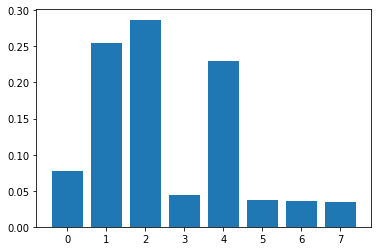

In [50]:
sp_dm=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)
for i in range(1,n_qubits+1):
    for j in range(1,n_qubits+1):
        sp_dm[2**(i-1),2**(j-1)]=dm[2**(i-1),2**(j-1)]

sp_dm=sp_dm/np.trace(sp_dm)
density_matrix_final_state_single_particle=DensityMatrix(sp_dm)

plt.bar(np.arange(2**n_qubits),density_matrix_final_state.probabilities())

(-2.2363417151214344-3.555536307531051e-32j) 0.6925098050507775


<BarContainer object of 8 artists>

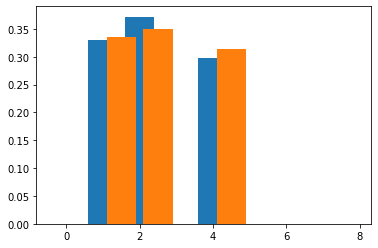

In [51]:
print(density_matrix_final_state_single_particle.expectation_value(hamiltonian_q)+7.8,state_fidelity(density_matrix_final_state,final_state_clean_single_particle))

plt.bar(np.arange(2**n_qubits),density_matrix_final_state_single_particle.probabilities())
plt.bar(np.arange(2**n_qubits)+0.5,final_state_clean_single_particle.probabilities())


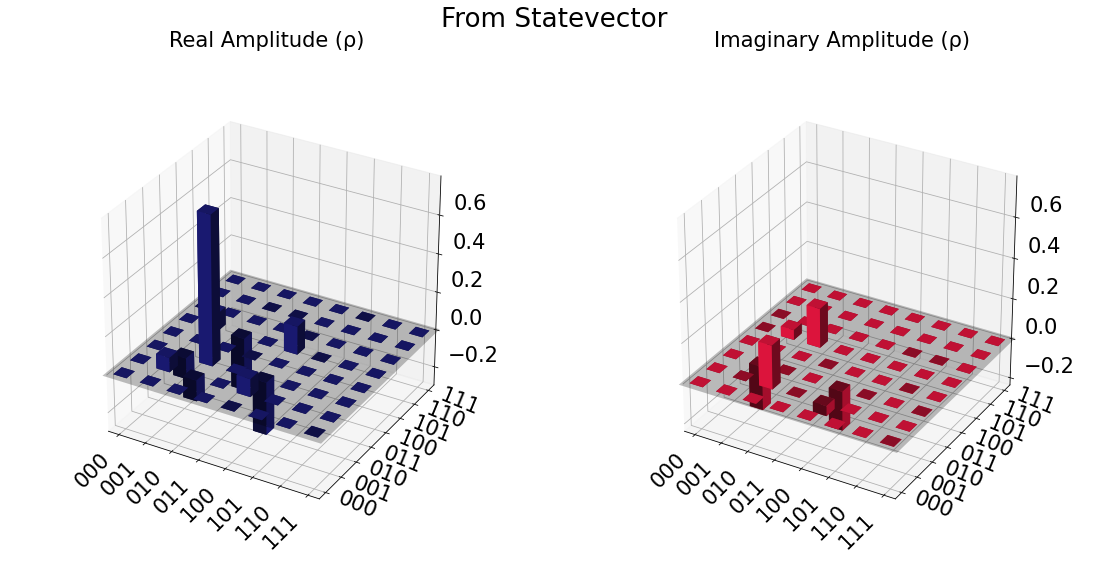

In [174]:
from qiskit.visualization import plot_bloch_vector
from qiskit.quantum_info import Statevector, DensityMatrix

from qiskit.visualization import plot_state_city
# Example state
sv = final_state_clean_single_particle              # |+> = (|0> + |1>)/sqrt(2)
dm = density_matrix_final_state_single_particle       # Completely mixed state


# Convert statevector to density matrix
dm_from_sv = DensityMatrix(sv)

# Plot side-by-side city plots (2D bar graphs)
# Plot first density matrix
plot_state_city(dm_from_sv, title="From Statevector", color=['midnightblue', 'crimson'])



# Plot second (possibly noisy) density matrix


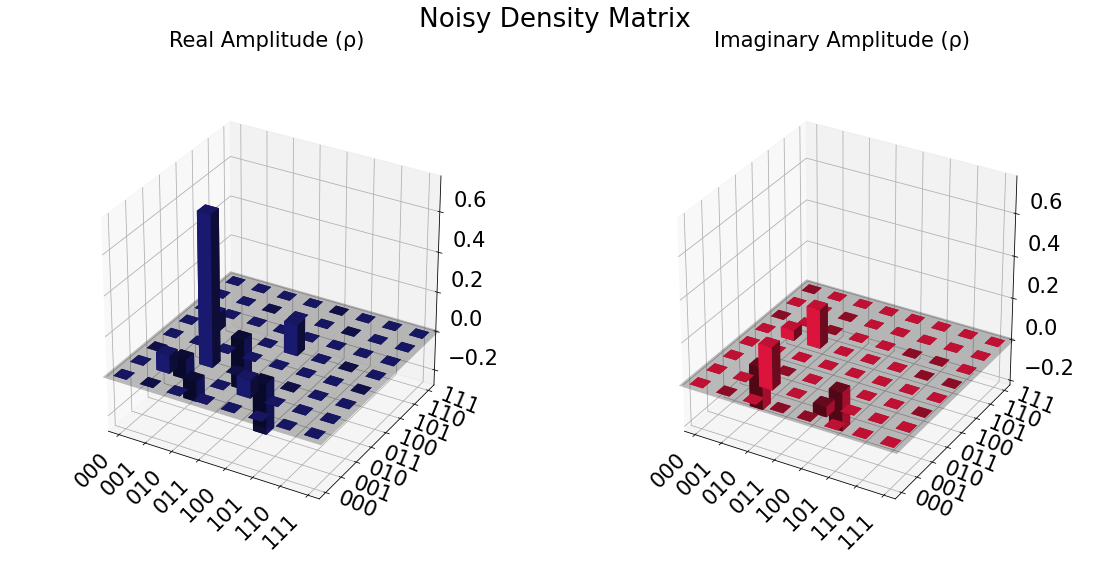

In [175]:
plot_state_city(density_matrix_final_state_single_particle, title="Noisy Density Matrix", color=['midnightblue', 'crimson'])


#### What about quantum optimal control with the time schedule?

In [53]:
class OptimalControlQiskitClean:
    
    def __init__(self,tf,time_steps,n_parameters,hamiltonian_q,hamiltonian_driver):
        
        self.omegas=2*np.pi*np.arange(1,n_parameters+1)*(1+np.random.uniform(-0.5,0.5,n_parameters))/tf
        self.time=np.linspace(0,tf,time_steps)
        self.tf=tf
        self.time_steps=time_steps
        self.parameters=np.zeros(4*n_parameters)
        self.final_psi=None
        self.hamiltonian_q=hamiltonian_q
        self.hamiltonian_driver=hamiltonian_driver
    def energy_quantum_annealing(self,parameters:np.ndarray):
        
        dim=parameters.shape[0]//4
        matrix_driver=(parameters[:dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[dim:2*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))
        matrix_target=(parameters[2*dim:3*dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[3*dim:4*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))

        h_driver=(1-self.time/self.tf)*(1+np.average(matrix_driver,axis=0))
        h_target=(self.time/self.tf)*(1+np.average(matrix_target,axis=0))
        
        initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
        initial_state.x([0])
        for n,t in enumerate(time):
            hamiltonian_t=(h_driver[n])*self.hamiltonian_driver+(h_target[n])*self.hamiltonian_q
            exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
            initial_state.append(exp_H_t,range(hamiltonian_t.num_qubits))
            
        
            
        # Define your basis gates
        #basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
        #basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
        basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
        transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
        final_state=Statevector(initial_state)
        
                # convert into the single particle state
        single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)

        for a in range(n_qubits):
            a_mb=2**(a)
            print(final_state.data.shape)
            single_particle_vector[a_mb]=final_state.data[a_mb]
        single_particle_vector=single_particle_vector/np.linalg.norm(single_particle_vector) 
        final_state_clean_single_particle=Statevector(single_particle_vector)
        self.final_psi=final_state_clean_single_particle
        print(final_state_clean_single_particle.expectation_value(hamiltonian_q).real)
        return final_state_clean_single_particle.expectation_value(hamiltonian_q).real
        
        

In [56]:
class OptimalControlQiskitNoise:
    
    def __init__(self,tf,time_steps,n_parameters,hamiltonian_q,hamiltonian_driver,noise_model):
        
        self.omegas=2*np.pi*np.arange(1,n_parameters+1)*(1+np.random.uniform(-0.5,0.5,n_parameters))/tf
        self.time=np.linspace(0,tf,time_steps)
        self.tf=tf
        self.time_steps=time_steps
        self.parameters=np.zeros(4*n_parameters)
        self.final_psi=None
        self.hamiltonian_q=hamiltonian_q
        self.hamiltonian_driver=hamiltonian_driver
        self.noise_model=noise_model
    def energy_quantum_annealing(self,parameters:np.ndarray):
        
        dim=parameters.shape[0]//4
        matrix_driver=(parameters[:dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[dim:2*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))
        matrix_target=(parameters[2*dim:3*dim,None]*np.sin(self.time[None,:]*self.omegas[:,None])+parameters[3*dim:4*dim,None]*np.cos(self.time[None,:]*self.omegas[:,None]))

        self.h_driver=(1-self.time/self.tf)*(1+np.average(matrix_driver,axis=0))
        self.h_target=(self.time/self.tf)*(1+np.average(matrix_target,axis=0))
        
        initial_state=QuantumCircuit(hamiltonian_q.num_qubits)
        initial_state.x([0])
        for n,t in enumerate(self.time):
            hamiltonian_t=(self.h_driver[n])*self.hamiltonian_driver+(self.h_target[n])*self.hamiltonian_q
            exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
            initial_state.append(exp_H_t,range(hamiltonian_t.num_qubits))
        
        # Define your basis gates
        #basis_gates_kingston = ['cz', 'id', 'rz', 'sx', 'x']
        #basis_gates_eagles= ['ecr', 'id', 'rz', 'sx', 'x']
        basis_gates_acheen=['cz', 'id', 'rz', 'rz', 'rzz', 'sx', 'x']
        transpiled_initial_state=transpile(initial_state, optimization_level=3,basis_gates=basis_gates_acheen)
        
        sim = AerSimulator(noise_model=self.noise_model)
        transpiled_initial_state.save_density_matrix()
        # Transpile and run
        tqc = transpile(transpiled_initial_state, sim,optimization_level=3)
        result = sim.run(tqc).result()
        
        dm = result.data(0)['density_matrix']
        
        sp_dm=np.zeros((2**n_qubits,2**n_qubits),dtype=np.complex128)
        for i in range(1,n_qubits+1):
            for j in range(1,n_qubits+1):
                sp_dm[2**(i-1),2**(j-1)]=np.asarray(dm)[2**(i-1),2**(j-1)]

        sp_dm=sp_dm/np.trace(sp_dm)
        density_matrix_final_state_single_particle=DensityMatrix(sp_dm)
        self.density_matrix_single_particle=density_matrix_final_state_single_particle
        print(density_matrix_final_state_single_particle.expectation_value(hamiltonian_q).real)
        self.parameters=parameters
        return density_matrix_final_state_single_particle.expectation_value(hamiltonian_q).real


In [57]:
from scipy.optimize import minimize

OCQ=OptimalControlQiskitNoise(tf=2,time_steps=20,n_parameters=10,hamiltonian_q=hamiltonian_q,hamiltonian_driver=hamiltonian_driver,noise_model=noise_model)

res = minimize(
                    OCQ.energy_quantum_annealing,
                    OCQ.parameters,
                    method='L-BFGS-B',
                    tol=10**-3,
                    options=None,
                    
                )

OCQ.parameters = res.x
energy = OCQ.energy_quantum_annealing(OCQ.parameters)
print(energy)
print(OCQ.parameters)


-10.03634171512143
-10.034191381818019
-10.034666983905876
-10.034441619496691
-10.033681515269558
-10.036341715105895
-10.033895148598972
-10.037616381884284
-10.033704669717858
-10.03604515643687
-10.033518578312774
-10.035941227510499
-10.034440914286034
-10.033298432730454
-10.034440895201666
-10.036045766411911
-10.034667042666078
-10.037616381883936
-10.034439819141486
-10.03518702280973
-10.034667012701188
-10.034441236536434
-10.036270990310296
-10.036341715188303
-10.034440950512229
-10.034435757717027
-10.036341715135078
-10.036040588851431
-10.035941227997926
-10.036270994406141
-10.034666987873306
-10.037616381844986
-10.037616381787014
-10.035941228165306
-10.034441158260679
-10.034665687994764
-10.036045184325824
-10.036044568476504
-10.037616381888405
-10.037616381884877
-10.036045296602033
-10.024734356247944
-10.026341526445286
-10.024509575090237
-10.02371646721075
-10.024734566217862
-10.024734388277043
-10.025929826882612
-10.027675677935262
-10.027675677935033
-10.

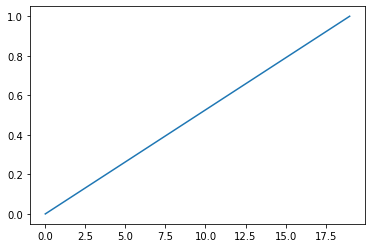

In [42]:
plt.plot(OCQ.h_target)
plt.show()

#### Run on a IBM machine

In [9]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis import SuzukiTrotter,QDrift
from qiskit.circuit.library import PauliEvolutionGate
from qiskit import transpile
from qiskit.quantum_info import Statevector

#final_state=Statevector(circuit_opt)
time_steps=100
tf=10
time=np.linspace(0,tf,time_steps)
dt=tf/time_steps
#b=0.8
#h=1-(1+b)*(time/tf)+b*(time/tf)**2
h=1-time/tf
circuit_time_evolution=QuantumCircuit(hamiltonian_q.num_qubits,hamiltonian_q.num_qubits)
circuit_time_evolution.x([0]) # initial state

energies_qiskit=np.zeros((time_steps))


for n,t in enumerate(time):
    hamiltonian_t=((h[n])*hamiltonian_driver+(1-h[n])*hamiltonian_q)
    exp_H_t=PauliEvolutionGate(hamiltonian_t,time=dt,synthesis=SuzukiTrotter(order=1))
    circuit_time_evolution.append(exp_H_t,range(hamiltonian_q.num_qubits))
    single_particle_vector=np.zeros(2**n_qubits,dtype=np.complex128)
    psi_for_fidelity=np.zeros(n_qubits,dtype=np.complex128)
    # for a in range(n_qubits):
    #     a_mb=2**(a)
    #     final_state=Statevector(circuit_time_evolution).data
    #     single_particle_vector[a_mb]=final_state[a_mb]
    #     psi_for_fidelity[a]=final_state[a_mb]
    # energies_qiskit[n]=Statevector(single_particle_vector).expectation_value(hamiltonian_t)
print(Statevector(circuit_time_evolution).expectation_value(hamiltonian_q))
transpiled_circuit_time_evolution=transpile(circuit_time_evolution.decompose(), optimization_level=3,basis_gates=['cx','s','h','rz','x'])

(-31.334163248207602+0j)


In [12]:
from qiskit_ibm_provider import IBMProvider
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke,FakeMarrakesh,FakeValenciaV2,FakeTorino
from qiskit_aer import StatevectorSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_experiments.test import PulseBackend
# Replace with your actual API token
# service = IBMProvider(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
# backends = service.backends()
# for backend in backends:
#     print(backend.name)
    

    
# # Load the service
# #service = QiskitRuntimeService(token='91830ee51d4a39179a63363dd51d2b588653b869a4cab814c29deb5ac3ded710d02c63902e330e53bbfb36994a605f76f6822b3e608a78b38cc8927e023b0ea9')
backend = FakeTorino()
# backend = service.get_backend("ibm_brisbane")

# service = QiskitRuntimeService()
# backend = service.least_busy(
#     operational=True, simulator=False, min_num_qubits=127
# )

# print(backend)
#backend=StatevectorSimulator()
 
estimator = Estimator(mode=backend)
options = estimator.options
# Turn on gate twirling.
options.twirling.enable_gates = True
options.twirling.num_randomizations = 60
options.twirling.shots_per_randomization = 100
options.resilience.pec_mitigation = True
options.resilience.pec_mitigation = True
# #options.resilience.pec.max_overhead = 300
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XpXm"

# options.resilience.zne_mitigation = True
# options.resilience.zne.noise_factors = (1, 2, 3,4,5,6)
# options.resilience.zne.extrapolator = "exponential"
# estimator.options.resilience.zne.amplifier = "pea"


pm = generate_preset_pass_manager(backend=backend, optimization_level=3)



transpiled_qc=pm.run(transpiled_circuit_time_evolution)
layout = transpiled_qc.layout

h_squared=(hamiltonian_q @ hamiltonian_q).simplify()
observables = [
    hamiltonian_q
]
observables = [
    [observable.apply_layout(layout) for observable in observable_set]
    for observable_set in observables
]


estimator_pub = (transpiled_qc ,observables)

transpiled_qc.draw()

#print(f">>> gate twirling is turned on: {sampler.options.twirling.enable_gates}")


job = estimator.run([estimator_pub])
result = job.result()

/opt/anaconda3/envs/qs-estimation_env/lib/python3.9/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'resilience': {'pec_mitigation': True}, 'twirling': {'enable_gates': True, 'num_randomizations': 60, 'shots_per_randomization': 100}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [13]:

import matplotlib.pyplot as plt 
from qiskit.visualization import plot_histogram
%matplotlib inline

print(np.sum(result[0].data.evs))

-37.79197246071122
